# Exploratory Data Analysis (EDA) - Lender-Centric Approach

**Project**: Loan Approval Decision Support System  
**Perspective**: Lender/Underwriting Team  
**Dataset**: HMDA 2024 Mortgage Application Data (Cleaned)  
**Date**: December 28, 2025

## Overview

This EDA explores mortgage application data from a **lender-centric perspective** to support underwriting decisions. Unlike consumer-facing models that predict outcomes, this analysis focuses on:

1. **Underwriting Risk Factors**: DTI proxies, income stability, loan sizing
2. **Geographic Market Context**: Property location economics
3. **Applicant Characteristics**: Co-borrower patterns, joint applications
4. **Business Impact**: Approval rates, risk distribution, portfolio composition

**Key Questions:**
- What separates approved from denied applications?
- Which underwriting factors show strongest predictive signal?
- Are there geographic patterns in approval decisions?
- How do co-borrower applications perform vs. single applicants?

**Target Audience**: Loan officers, underwriters, risk management teams

In [34]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(" Libraries loaded successfully")

 Libraries loaded successfully


In [35]:
# ============================================================================
# LOAD CLEANED DATA
# ============================================================================

import os
from pathlib import Path

# Set up path - works from notebooks directory or project root
if Path('data/processed/cleaned_data.csv').exists():
    data_path = 'data/processed/cleaned_data.csv'
else:
    data_path = '../data/processed/cleaned_data.csv'

print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path, low_memory=False)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape[0]:,} applications × {df.shape[1]} features")
print(f"Data Range: {df['activity_year'].min()} - {df['activity_year'].max()}" if 'activity_year' in df.columns else "2024 HMDA Data")
print(f"Target: target (1=approved, 0=denied)")

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Loading data from: data/processed/cleaned_data.csv
DATASET OVERVIEW

Shape: 493,568 applications × 74 features
Data Range: 2024 - 2024
Target: target (1=approved, 0=denied)

First 5 rows:


,unnamed:_0,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,lien_status,total_units,conforming_loan_limit,...,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,target,loan_type_Federal Housing Administration insured (FHA),loan_type_USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA),loan_type_Veterans Affairs guaranteed (VA),construction_method_Site-Built
0,0,2024,549300DD4R4SYK5RAQ92,34980,0TN,47043.0,47043060502,First Lien,Single Family (1-4 Units),Conforming,...,101700,8.8,762,1137,48,1.0,0,0,0,1
1,1,2024,549300DD4R4SYK5RAQ92,99999,0WV,54109.0,54109002902,First Lien,Single Family (1-4 Units),Conforming,...,67600,10.3,1146,1647,38,0.0,0,1,0,0
2,3,2024,549300DD4R4SYK5RAQ92,24660,0NC,37081.0,37081017102,First Lien,Single Family (1-4 Units),Conforming,...,80700,10.5,728,943,41,1.0,0,0,0,1
3,5,2024,549300DD4R4SYK5RAQ92,14580,0MT,30031.0,30031000104,First Lien,Single Family (1-4 Units),Conforming,...,109000,8.4,644,1022,23,1.0,1,0,0,1
4,6,2024,549300DD4R4SYK5RAQ92,39300,0RI,44007.0,44007011702,First Lien,Single Family (1-4 Units),Conforming,...,113200,12.0,1108,1537,62,1.0,0,0,0,1


In [36]:
df.income = df.income.astype(float) * 1000
df.state_code = df.state_code.str.zfill(3)
df.county_code = df.county_code.str.zfill(5)

df[['income', 'state_code', 'county_code']]

,income,state_code,county_code
0,147000.0,0TN,47043.0
1,65000.0,0WV,54109.0
2,115000.0,0NC,37081.0
3,178000.0,0MT,30031.0
4,238000.0,0RI,44007.0
...,...,...,...
493563,140000.0,0NY,36101.0
493564,83000.0,0NY,36067.0
493565,159000.0,0NY,36067.0
493566,104000.0,0NY,36067.0


In [37]:
# ============================================================================
# DATA TYPES & BASIC STATISTICS
# ============================================================================

# Data is already cleaned; verify key columns exist
print("="*80)
print("TARGET DISTRIBUTION")
print("="*80)
print(f"\nTarget Variable:")
print(df['target'].value_counts())
print(f"\nApproval Rate: {df['target'].mean():.2%}")
print(f"Denial Rate: {(1 - df['target'].mean()):.2%}")

print("\n" + "="*80)
print("KEY UNDERWRITING VARIABLES")
print("="*80)

# Define key underwriting variables (lowercase)
underwriting_vars = ['income', 'loan_amount', 'property_value', 'interest_rate', 
                     'loan_term', 'total_loan_costs', 'debt_to_income_ratio']
available_vars = [v for v in underwriting_vars if v in df.columns]

if available_vars:
    # Summary statistics
    summary_stats = df[available_vars].describe()
    print("\n", summary_stats)
else:
    print("\nKey underwriting variables not found in dataset.")

print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(f"\nNumeric columns: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical columns: {len(df.select_dtypes(include=['object']).columns)}")
print(f"Total columns: {len(df.columns)}")

TARGET DISTRIBUTION

Target Variable:
target
1.0    442218
0.0     51350
Name: count, dtype: int64

Approval Rate: 89.60%
Denial Rate: 10.40%

KEY UNDERWRITING VARIABLES

              income   loan_amount  property_value  interest_rate  \
count  4.935680e+05  4.935680e+05    4.935680e+05  493568.000000   
mean   1.501475e+05  3.604713e+05    4.676101e+05       5.840613   
std    9.158074e+05  2.733715e+05    3.913132e+05       2.309065   
min    1.000000e+03  5.000000e+03    5.000000e+03       0.000000   
25%    7.200000e+04  1.950000e+05    2.450000e+05       5.875000   
50%    1.070000e+05  3.050000e+05    3.650000e+05       6.500000   
75%    1.650000e+05  4.450000e+05    5.550000e+05       6.990000   
max    4.000000e+08  2.995000e+06    4.995000e+06      15.000000   

           loan_term  total_loan_costs  
count  493568.000000      4.935680e+05  
mean      347.859861      6.614648e+03  
std        47.452850      9.147661e+03  
min         0.000000      0.000000e+00  
25%       

In [38]:
# ============================================================================
# MISSING VALUES & DATA QUALITY
# ============================================================================
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum().values / len(df) * 100).round(2),
    'Unique_Values': df.nunique().values,
    'Dtype': df.dtypes.values
})

missing_data = missing_data[missing_data['Missing_Percent'] > 0].sort_values('Missing_Percent', ascending=False)

if len(missing_data) > 0:
    print("\n✅ Columns with Missing Values:")
    print(missing_data[['Column', 'Missing_Count', 'Missing_Percent', 'Unique_Values']].head(20).to_string(index=False))
else:
    print("\n✅ No missing values detected - Data is clean!")

print("\n" + "="*80)
print("UNDERWRITING VARIABLE COMPLETENESS")
print("="*80)

# Check completeness of key underwriting variables (lowercase)
key_vars = ['income', 'loan_amount', 'property_value', 'derived_race', 'derived_ethnicity', 'derived_sex']
available_key_vars = [v for v in key_vars if v in df.columns]

if available_key_vars:
    completeness = pd.DataFrame({
        'Variable': available_key_vars,
        'Complete': [df[v].notna().sum() for v in available_key_vars],
        'Missing': [df[v].isna().sum() for v in available_key_vars],
        'Completeness_Rate': [(df[v].notna().sum() / len(df) * 100).round(2) for v in available_key_vars]
    })
    print("\n", completeness.to_string(index=False))

else:    print("\nKey variables assessment: Data is pre-cleaned.")

DATA QUALITY ASSESSMENT

✅ Columns with Missing Values:
                  Column  Missing_Count  Missing_Percent  Unique_Values
    debt_to_income_ratio          42405             8.59             19
              state_code           5462             1.11             53
  applicant_age_above_62            298             0.06              2
   applicant_ethnicity_1            269             0.05              8
        applicant_race_1            220             0.04             18
co_applicant_ethnicity_1             75             0.02              9
     co_applicant_race_1             74             0.01             19

UNDERWRITING VARIABLE COMPLETENESS

          Variable  Complete  Missing  Completeness_Rate
           income    493568        0              100.0
      loan_amount    493568        0              100.0
   property_value    493568        0              100.0
     derived_race    493568        0              100.0
derived_ethnicity    493568        0              

In [39]:
# ============================================================================
# DEBT-TO-INCOME RATIO (DTI) ANALYSIS
# ============================================================================
print("="*80)
print("DEBT-TO-INCOME RATIO (DTI) ANALYSIS")
print("="*80)

# Check if debt_to_income_ratio column exists in the dataset
if 'debt_to_income_ratio' in df.columns:
    print("\n✅ debt_to_income_ratio column found in dataset")
    
    # Check data type
    dti_dtype = df['debt_to_income_ratio'].dtype
    print(f"Data type: {dti_dtype}")
    print(f"Sample values: {df['debt_to_income_ratio'].head(10).tolist()}\n")
    
    # Check if data is numeric or categorical
    is_numeric = pd.api.types.is_numeric_dtype(df['debt_to_income_ratio'])
    
    if not is_numeric:
        print("ℹ️  DTI data is categorical/binned (not continuous numeric)")
        print("Analyzing categorical DTI distribution...\n")
        
        # Distribution analysis
        print("="*80)
        print("DTI CATEGORY DISTRIBUTION")
        print("="*80)
        
        dti_counts = df['debt_to_income_ratio'].value_counts(dropna=False).sort_index()
        dti_pcts = df['debt_to_income_ratio'].value_counts(normalize=True, dropna=False).sort_index() * 100
        
        distribution = pd.DataFrame({
            'Count': dti_counts,
            'Percentage': dti_pcts
        })
        print(distribution)
        
        # Analysis by loan decision
        print("\n" + "="*80)
        print("DTI DISTRIBUTION BY LOAN DECISION")
        print("="*80)
        
        approval_by_dti = df.groupby('debt_to_income_ratio')['target'].agg([
            ('Total', 'count'),
            ('Approved', lambda x: (x == 1).sum()),
            ('Denied', lambda x: (x == 0).sum()),
            ('Approval_Rate', 'mean')
        ])
        approval_by_dti['Approval_Rate'] = approval_by_dti['Approval_Rate'] * 100
        print(approval_by_dti.sort_index())
        
        # Chi-square test for independence
        print("\n" + "-"*80)
        print("Statistical Association Test")
        print("-"*80)
        from scipy.stats import chi2_contingency
        
        contingency_table = pd.crosstab(df['debt_to_income_ratio'], df['target'])
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-Square Test: χ² = {chi2:.2f}, p-value = {pval:.4e}")
        print(f"{'✅ Significant association between DTI and approval decision' if pval < 0.05 else '⚠️  No significant association'}")
        
        # Identify high-risk DTI categories
        print("\n" + "="*80)
        print("DTI RISK ASSESSMENT")
        print("="*80)
        print("Categories with approval rates below median:")
        median_approval = approval_by_dti['Approval_Rate'].median()
        print(f"Median approval rate: {median_approval:.2f}%\n")
        
        high_risk = approval_by_dti[approval_by_dti['Approval_Rate'] < median_approval]
        if len(high_risk) > 0:
            print(high_risk[['Total', 'Approval_Rate']].sort_values('Approval_Rate'))
        else:
            print("All categories are at or above median approval rate")
    
    else:
        # Numeric DTI analysis
        print("✅ DTI data is numeric (continuous)")
        print("\nDescriptive Statistics:")
        print(df['debt_to_income_ratio'].describe())
        
        # Statistics by approval decision
        print("\n" + "="*80)
        print("DTI BY LOAN DECISION")
        print("="*80)
        print(df.groupby('target')['debt_to_income_ratio'].describe())
        
        print(f"\nMedian DTI by Decision:")
        approved_dti_median = df[df['target'] == 1]['debt_to_income_ratio'].median()
        denied_dti_median = df[df['target'] == 0]['debt_to_income_ratio'].median()
        print(f"  Approved: {approved_dti_median:.2f}%")
        print(f"  Denied: {denied_dti_median:.2f}%")
        print(f"  Difference: {abs(denied_dti_median - approved_dti_median):.2f} percentage points")
        
        # Statistical test
        from scipy.stats import mannwhitneyu
        approved_dti = df[df['target'] == 1]['debt_to_income_ratio'].dropna()
        denied_dti = df[df['target'] == 0]['debt_to_income_ratio'].dropna()
        stat, pval = mannwhitneyu(approved_dti, denied_dti)
        print(f"\nMann-Whitney U Test: p-value = {pval:.4e}")
        print(f"{'✅ Significant difference' if pval < 0.05 else '⚠️  No significant difference'}")
    
else:
    print("\n⚠️  debt_to_income_ratio column NOT FOUND in dataset")
    print("This column may need to be calculated or is not available in the current data.")

DEBT-TO-INCOME RATIO (DTI) ANALYSIS

✅ debt_to_income_ratio column found in dataset
Data type: object
Sample values: ['49', '42', '20%-<30%', '50%-60%', '30%-<36%', '20%-<30%', '44', '36', '36', '43']

ℹ️  DTI data is categorical/binned (not continuous numeric)
Analyzing categorical DTI distribution...

DTI CATEGORY DISTRIBUTION
                      Count  Percentage
debt_to_income_ratio                   
20%-<30%              57633   11.676810
30%-<36%              66562   13.485882
36                    13464    2.727892
37                    14266    2.890382
38                    14992    3.037474
39                    16061    3.254060
40                    16903    3.424655
41                    17322    3.509547
42                    18676    3.783876
43                    18063    3.659678
44                    19921    4.036121
45                    16540    3.351109
46                    16878    3.419590
47                    17410    3.527376
48                    18642  

In [40]:
# ============================================================================
# DEFINE RISK FLAGS BASED ON DTI
# ============================================================================
print("="*80)
print("DTI RISK FLAG CREATION")
print("="*80)

if 'debt_to_income_ratio' in df.columns:
    print("\n📋 Creating risk flags based on DTI categories...")
    
    # Define DTI risk mapping based on standard lending guidelines
    # Industry standards:
    # - DTI < 36%: Low Risk (Strong borrower)
    # - DTI 36-43%: Moderate Risk (Acceptable)
    # - DTI 43-50%: Elevated Risk (Caution)
    # - DTI > 50%: High Risk (Significant concern)
    
    dti_risk_mapping = {
        '<20%': 'Low Risk',
        '20%-<30%': 'Low Risk',
        '30%-<36%': 'Low Risk',
        '36': 'Moderate Risk',
        '>36': 'High Risk',
        '37': 'Moderate Risk',
        '38': 'Moderate Risk',
        '39': 'Moderate Risk',
        '40': 'Moderate Risk',
        '41': 'Moderate Risk',
        '42': 'Moderate Risk',
        '43': 'Elevated Risk',
        '44': 'Elevated Risk',
        '45': 'Elevated Risk',
        '46': 'Elevated Risk',
        '47': 'Elevated Risk',
        '48': 'Elevated Risk',
        '49': 'Elevated Risk',
        '50%-60%': 'High Risk',
        '>60%': 'High Risk',
        'Exempt': 'Unknown'
    }
    
    # Apply risk mapping
    df['dti_risk_flag'] = df['debt_to_income_ratio'].map(dti_risk_mapping)
    
    # Handle any unmapped values
    unmapped_count = df['dti_risk_flag'].isna().sum()
    if unmapped_count > 0:
        print(f"⚠️  {unmapped_count} records with unmapped DTI values")
        unmapped_values = df[df['dti_risk_flag'].isna()]['debt_to_income_ratio'].unique()
        print(f"   Unmapped DTI values: {unmapped_values}")
        df['dti_risk_flag'] = df['dti_risk_flag'].fillna('Unknown')
    
    # Display risk flag distribution
    print("\n" + "="*80)
    print("DTI RISK FLAG DISTRIBUTION")
    print("="*80)
    
    risk_dist = df['dti_risk_flag'].value_counts()
    risk_pct = df['dti_risk_flag'].value_counts(normalize=True) * 100
    
    risk_summary = pd.DataFrame({
        'Count': risk_dist,
        'Percentage': risk_pct
    })
    print(risk_summary)
    
    # Approval rates by risk flag
    print("\n" + "="*80)
    print("LOAN APPROVAL BY DTI RISK FLAG")
    print("="*80)
    
    approval_by_risk = df.groupby('dti_risk_flag')['target'].agg([
        ('Total_Loans', 'count'),
        ('Approved', lambda x: (x == 1).sum()),
        ('Denied', lambda x: (x == 0).sum()),
        ('Approval_Rate', 'mean')
    ])
    approval_by_risk['Approval_Rate'] = approval_by_risk['Approval_Rate'] * 100
    
    # Sort by risk level (custom order)
    risk_order = ['Low Risk', 'Moderate Risk', 'Elevated Risk', 'High Risk', 'Unknown']
    approval_by_risk = approval_by_risk.reindex(
        [r for r in risk_order if r in approval_by_risk.index]
    )
    
    print(approval_by_risk)
    
    # Key insights
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    
    if 'Low Risk' in approval_by_risk.index and 'High Risk' in approval_by_risk.index:
        low_risk_approval = approval_by_risk.loc['Low Risk', 'Approval_Rate']
        high_risk_approval = approval_by_risk.loc['High Risk', 'Approval_Rate']
        diff = low_risk_approval - high_risk_approval
        
        print(f"✓ Low Risk DTI approval rate: {low_risk_approval:.2f}%")
        print(f"✓ High Risk DTI approval rate: {high_risk_approval:.2f}%")
        print(f"✓ Approval rate difference: {diff:.2f} percentage points")
        
        if diff > 10:
            print("\n⚠️  SIGNIFICANT: DTI is a strong predictor of loan approval")
        else:
            print("\nℹ️  DTI shows moderate predictive value for loan approval")
    
    print(f"\n✅ DTI risk flag created and added to dataset as 'dti_risk_flag'")
    
else:
    print("\n⚠️  Cannot create DTI risk flags - debt_to_income_ratio column not found")

DTI RISK FLAG CREATION

📋 Creating risk flags based on DTI categories...
⚠️  42405 records with unmapped DTI values
   Unmapped DTI values: [nan]

DTI RISK FLAG DISTRIBUTION
                Count  Percentage
dti_risk_flag                    
Low Risk       141223   28.612673
Elevated Risk  134798   27.310928
Moderate Risk  111684   22.627885
High Risk       63458   12.856992
Unknown         42405    8.591521

LOAN APPROVAL BY DTI RISK FLAG
               Total_Loans  Approved  Denied  Approval_Rate
dti_risk_flag                                              
Low Risk            141223    130985   10238      92.750473
Moderate Risk       111684    105051    6633      94.060922
Elevated Risk       134798    126096    8702      93.544415
High Risk            63458     39476   23982      62.208075
Unknown              42405     40610    1795      95.767009

KEY INSIGHTS
✓ Low Risk DTI approval rate: 92.75%
✓ High Risk DTI approval rate: 62.21%
✓ Approval rate difference: 30.54 percentage po

In [41]:
# ============================================================================
# INCOME ANALYSIS
# ============================================================================
print("="*80)
print("INCOME DISTRIBUTION ANALYSIS")
print("="*80)

print(f"income Statistics by Decision:")
print(df.groupby('target')['income'].describe())

print(f"\n Median income:")
print(f"  Approved: ${df[df['target'] == 1]['income'].median():,.0f}")
print(f"  Denied: ${df[df['target'] == 0]['income'].median():,.0f}")

# Income Classification
income_bins = [0, 30000, 60000, 100000, 150000, 200000, np.inf]
income_labels = ['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High', 'Very High']
df['income_class'] = pd.cut(df['income'], bins=income_bins, labels=income_labels)
print(df['income_class'].value_counts())

# Approval Rate % by Income Class
approval_rate_by_income_class = df.groupby('income_class')['target'].agg(lambda x: ((x==1).sum() / x.count()) * 100)
print("\nApproval Rate by Income Class:")
print(approval_rate_by_income_class)


INCOME DISTRIBUTION ANALYSIS
income Statistics by Decision:
           count           mean           std     min      25%       50%  \
target                                                                     
0.0      51350.0  135953.320351  2.294076e+06  1000.0  52000.0   81000.0   
1.0     442218.0  151795.709356  5.700586e+05  1000.0  75000.0  110000.0   

             75%          max  
target                         
0.0     125000.0  400000000.0  
1.0     169000.0  149000000.0  

 Median income:
  Approved: $110,000
  Denied: $81,000
income_class
Middle          148923
Upper-Middle    121194
Very High        83908
Lower-Middle     71796
High             61038
Low               6709
Name: count, dtype: int64

Approval Rate by Income Class:
income_class
Low             50.186317
Lower-Middle    81.239902
Middle          89.315955
Upper-Middle    92.101919
High            93.644942
Very High       93.830147
Name: target, dtype: float64


In [42]:
df = pd.read_csv('data/processed/loan_data_cleaned_v2.csv')

## Visualization 1: Core Underwriting Metrics

This section visualizes the key underwriting factors that drive loan approval decisions:
1. **Debt-To-Income Ratio**: Shows decision patterns across DTI categories
2. **Income Distribution**: Compares applicant income levels
3. **Loan Amount Distribution**: Analyzes loan sizing patterns
4. **Approval Rate by Mortgage Risk**: Shows decision patterns across risk categories


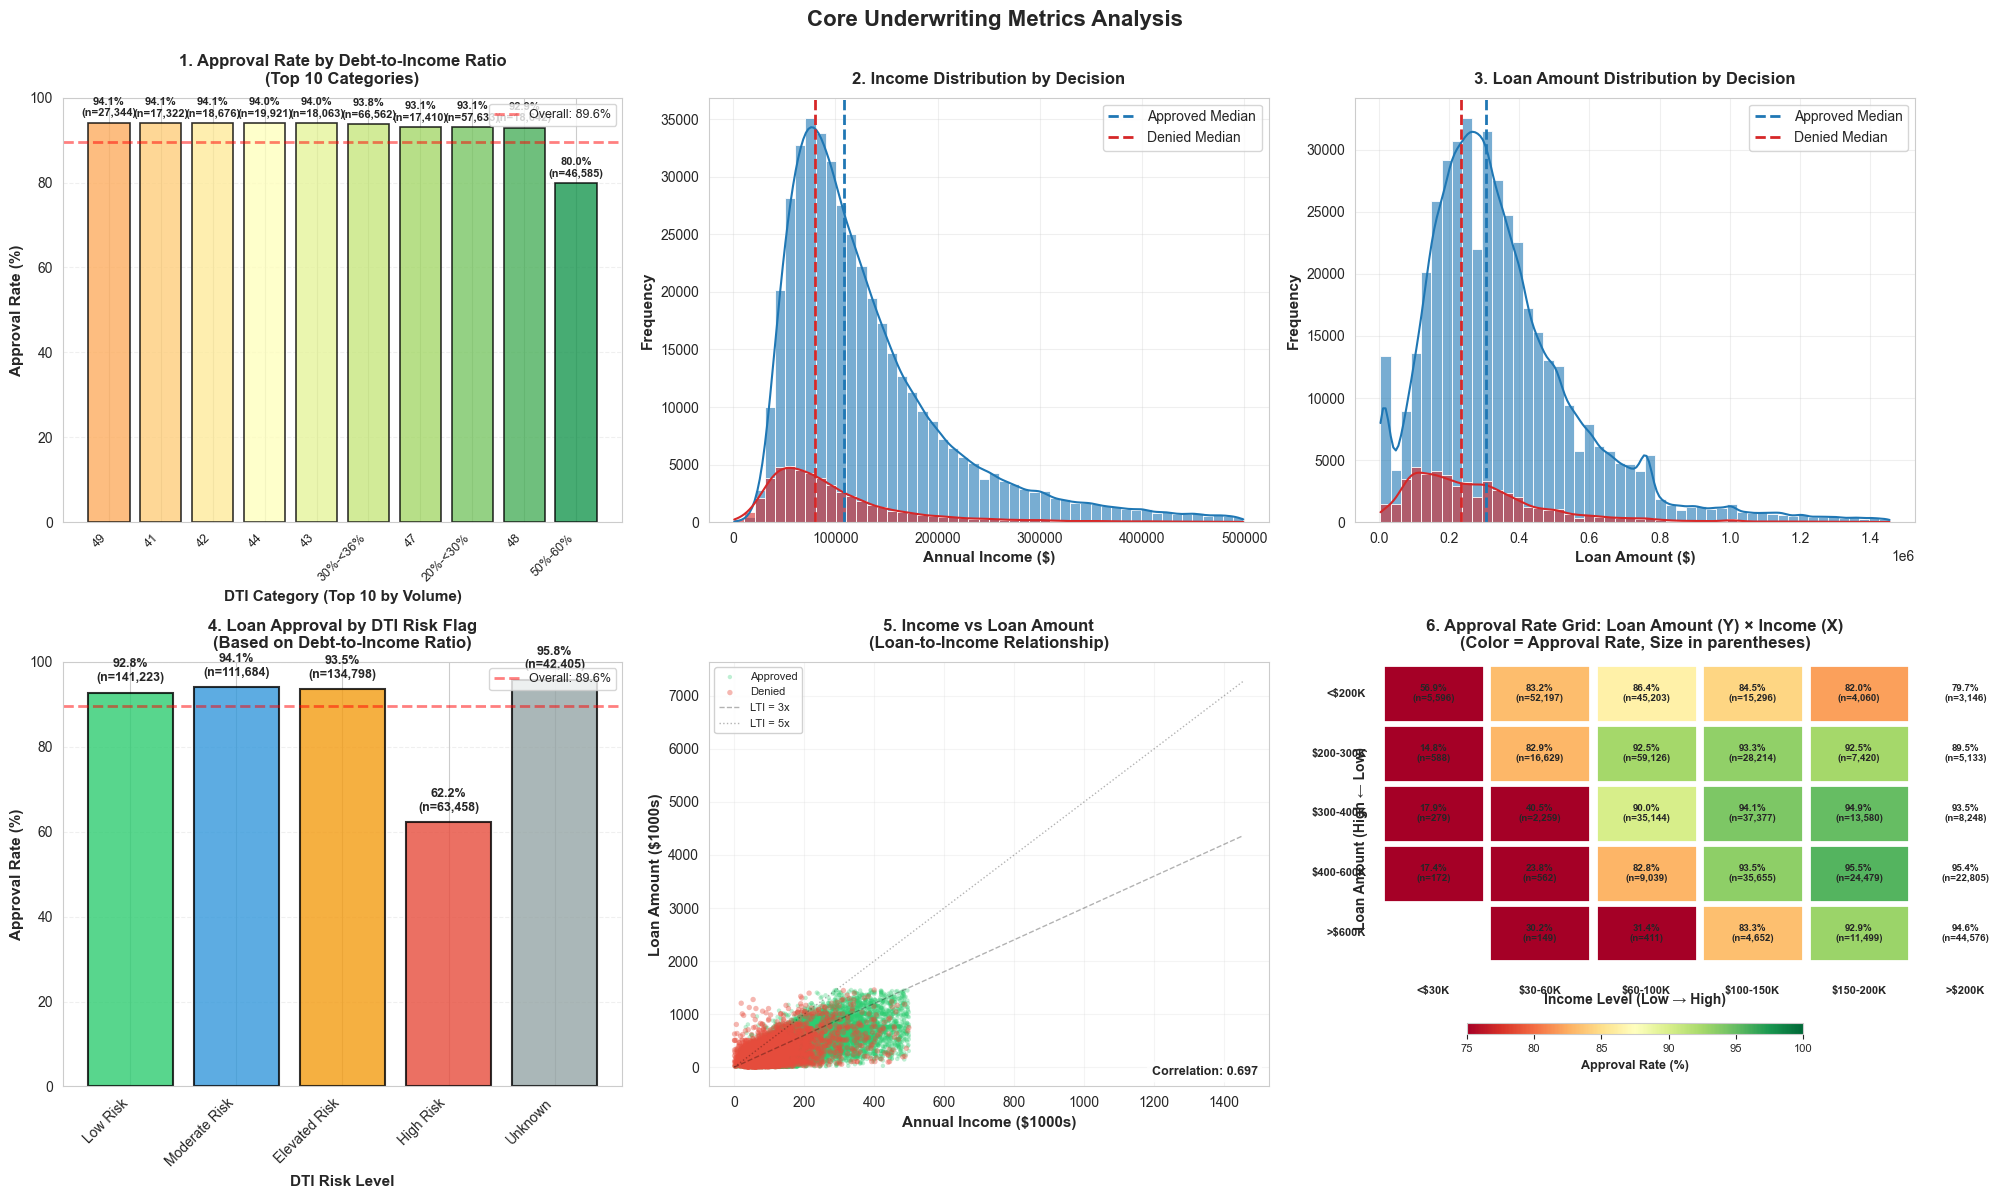


✅ Visualization saved: reports/eda_underwriting_metrics.png


In [43]:
# ============================================================================
# VISUALIZATION 1: CORE UNDERWRITING METRICS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Core Underwriting Metrics Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Approval Rate by DTI Category (Top 10 Categories)
ax1 = axes[0, 0]
if 'debt_to_income_ratio' in df.columns:
    # Get top 10 DTI categories by application volume
    top_dti_categories = df['debt_to_income_ratio'].value_counts().head(10).index.tolist()
    df_dti_top = df[df['debt_to_income_ratio'].isin(top_dti_categories)].copy()
    
    # Calculate approval rates for top categories
    dti_cat_approval = df_dti_top.groupby('debt_to_income_ratio')['target'].agg(['mean', 'count']).reset_index()
    dti_cat_approval['approval_rate'] = dti_cat_approval['mean'] * 100
    
    # Sort by approval rate descending
    dti_cat_approval = dti_cat_approval.sort_values('approval_rate', ascending=False)
    
    # Create color gradient based on approval rate
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(dti_cat_approval)))
    
    bars = ax1.bar(range(len(dti_cat_approval)), dti_cat_approval['approval_rate'],
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    ax1.set_xticks(range(len(dti_cat_approval)))
    ax1.set_xticklabels(dti_cat_approval['debt_to_income_ratio'], fontsize=9, rotation=45, ha='right')
    ax1.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax1.set_xlabel('DTI Category (Top 10 by Volume)', fontsize=11, fontweight='bold')
    ax1.set_title('1. Approval Rate by Debt-to-Income Ratio\n(Top 10 Categories)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax1.set_ylim(0, 100)
    
    # Add overall approval rate reference line
    overall_approval = df['target'].mean() * 100
    ax1.axhline(overall_approval, color='red', linestyle='--', linewidth=2, alpha=0.5,
                label=f'Overall: {overall_approval:.1f}%')
    
    # Add value labels on bars
    for i, (bar, row) in enumerate(zip(bars, dti_cat_approval.itertuples())):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%\n(n={row.count:,})',
                 ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax1.legend(loc='upper right', fontsize=9)
else:
    ax1.text(0.5, 0.5, 'DTI data not available', ha='center', va='center', fontsize=12)
    ax1.set_title('1. Approval Rate by DTI Category', fontsize=12, fontweight='bold', pad=10)

# Plot 2: Income Distribution
ax2 = axes[0, 1]
if 'income' in df.columns:
    df_income_plot = df[df['income'] < 500000].copy()  # Focus on main range
    sns.histplot(data=df_income_plot, x='income', hue='target',
                 bins=50, kde=True, ax=ax2, palette={1: '#1f77b4', 0: '#d62728'}, alpha=0.6)
    ax2.axvline(df_income_plot[df_income_plot['target'] == 1]['income'].median(), 
                color='#1f77b4', linestyle='--', linewidth=2, label='Approved Median')
    ax2.axvline(df_income_plot[df_income_plot['target'] == 0]['income'].median(), 
                color='#d62728', linestyle='--', linewidth=2, label='Denied Median')
    ax2.set_xlabel('Annual Income ($)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('2. Income Distribution by Decision', fontsize=12, fontweight='bold', pad=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Income data not available', ha='center', va='center', fontsize=12)
    ax2.set_title('2. Income Distribution', fontsize=12, fontweight='bold', pad=10)

# Plot 3: Loan Amount Distribution
ax3 = axes[0, 2]
if 'loan_amount' in df.columns:
    df_loan_plot = df[(df['loan_amount'] > 0) & (df['loan_amount'] < df['loan_amount'].quantile(0.99))].copy()
    sns.histplot(data=df_loan_plot, x='loan_amount', hue='target',
                 bins=50, kde=True, ax=ax3, palette={1: '#1f77b4', 0: '#d62728'}, alpha=0.6)
    ax3.axvline(df_loan_plot[df_loan_plot['target'] == 1]['loan_amount'].median(), 
                color='#1f77b4', linestyle='--', linewidth=2, label='Approved Median')
    ax3.axvline(df_loan_plot[df_loan_plot['target'] == 0]['loan_amount'].median(), 
                color='#d62728', linestyle='--', linewidth=2, label='Denied Median')
    ax3.set_xlabel('Loan Amount ($)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('3. Loan Amount Distribution by Decision', fontsize=12, fontweight='bold', pad=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Loan amount data not available', ha='center', va='center', fontsize=12)
    ax3.set_title('3. Loan Amount Distribution', fontsize=12, fontweight='bold', pad=10)

# Plot 4: Approval Rate by DTI Risk Flag
ax4 = axes[1, 0]
if 'dti_risk_flag' in df.columns:
    # Define risk order and colors
    risk_order = ['Low Risk', 'Moderate Risk', 'Elevated Risk', 'High Risk', 'Unknown']
    risk_colors = {'Low Risk': '#2ecc71', 'Moderate Risk': '#3498db', 
                   'Elevated Risk': '#f39c12', 'High Risk': '#e74c3c', 'Unknown': '#95a5a6'}
    
    # Calculate approval rates by risk flag
    dti_risk_approval = df.groupby('dti_risk_flag')['target'].agg(['mean', 'count']).reset_index()
    dti_risk_approval['approval_rate'] = dti_risk_approval['mean'] * 100
    
    # Sort by risk order
    dti_risk_approval['sort_order'] = dti_risk_approval['dti_risk_flag'].map(
        {risk: i for i, risk in enumerate(risk_order)})
    dti_risk_approval = dti_risk_approval.sort_values('sort_order')
    
    # Create bar colors
    bar_colors = [risk_colors.get(risk, '#95a5a6') for risk in dti_risk_approval['dti_risk_flag']]
    
    bars = ax4.bar(range(len(dti_risk_approval)), dti_risk_approval['approval_rate'], 
                   color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax4.set_xticks(range(len(dti_risk_approval)))
    ax4.set_xticklabels(dti_risk_approval['dti_risk_flag'], rotation=45, ha='right', fontsize=10)
    ax4.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax4.set_xlabel('DTI Risk Level', fontsize=11, fontweight='bold')
    ax4.set_title('4. Loan Approval by DTI Risk Flag\n(Based on Debt-to-Income Ratio)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for i, (bar, row) in enumerate(zip(bars, dti_risk_approval.itertuples())):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}%\n(n={row.count:,})',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add reference line at overall approval rate
    overall_approval = df['target'].mean() * 100
    ax4.axhline(overall_approval, color='red', linestyle='--', linewidth=2, alpha=0.5,
                label=f'Overall: {overall_approval:.1f}%')
    ax4.legend(loc='upper right', fontsize=9)
    
else:
    ax4.text(0.5, 0.5, 'DTI risk flag not available\n(Run DTI risk analysis first)', 
             ha='center', va='center', fontsize=11)
    ax4.set_title('4. Approval Rate by DTI Risk Flag', fontsize=12, fontweight='bold', pad=10)

# Plot 5: Income vs Loan Amount (Multivariate Analysis)
ax5 = axes[1, 1]
if 'income' in df.columns and 'loan_amount' in df.columns:
    # Sample data for better visualization (use 10% sample for scatter plot)
    df_sample = df.sample(n=min(50000, len(df)), random_state=42)
    df_sample = df_sample[(df_sample['income'] > 0) & (df_sample['income'] < 500000) & 
                          (df_sample['loan_amount'] > 0) & (df_sample['loan_amount'] < df['loan_amount'].quantile(0.99))]
    
    # Scatter plot with color by approval decision
    approved = df_sample[df_sample['target'] == 1]
    denied = df_sample[df_sample['target'] == 0]
    
    ax5.scatter(approved['income']/1000, approved['loan_amount']/1000, 
                alpha=0.3, s=10, c='#2ecc71', label='Approved', edgecolors='none')
    ax5.scatter(denied['income']/1000, denied['loan_amount']/1000, 
                alpha=0.4, s=15, c='#e74c3c', label='Denied', edgecolors='none')
    
    # Add diagonal reference lines for loan-to-income ratios
    max_val = max(df_sample['income'].max()/1000, df_sample['loan_amount'].max()/1000)
    x_line = np.linspace(0, max_val, 100)
    ax5.plot(x_line, x_line * 3, 'k--', alpha=0.3, linewidth=1, label='LTI = 3x')
    ax5.plot(x_line, x_line * 5, 'k:', alpha=0.3, linewidth=1, label='LTI = 5x')
    
    ax5.set_xlabel('Annual Income ($1000s)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Loan Amount ($1000s)', fontsize=11, fontweight='bold')
    ax5.set_title('5. Income vs Loan Amount\n(Loan-to-Income Relationship)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax5.legend(loc='upper left', fontsize=8, framealpha=0.9)
    ax5.grid(True, alpha=0.2)
    
    # Add correlation coefficient
    corr = df_sample[['income', 'loan_amount']].corr().iloc[0, 1]
    ax5.text(0.98, 0.02, f'Correlation: {corr:.3f}', 
             transform=ax5.transAxes, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=9, fontweight='bold')
else:
    ax5.text(0.5, 0.5, 'Income or Loan Amount data not available', 
             ha='center', va='center', fontsize=12)
    ax5.set_title('5. Income vs Loan Amount', fontsize=12, fontweight='bold', pad=10)

# Plot 6: Heatmap Grid - Loan Amount vs Income (Colored by Approval Rate)
ax6 = axes[1, 2]
if 'income' in df.columns and 'loan_amount' in df.columns:
    # Create income and loan amount bins (ordered from low to high)
    income_bins = [0, 30000, 60000, 100000, 150000, 200000, np.inf]
    income_labels = ['<$30K', '$30-60K', '$60-100K', '$100-150K', '$150-200K', '>$200K']
    
    loan_bins = [0, 200000, 300000, 400000, 600000, 10000000]
    loan_labels = ['<$200K', '$200-300K', '$300-400K', '$400-600K', '>$600K']
    
    # Filter valid data
    df_tree = df[(df['income'] > 0) & (df['loan_amount'] > 0)].copy()
    
    # Create bins
    df_tree['income_bin'] = pd.cut(df_tree['income'], bins=income_bins, labels=income_labels, include_lowest=True)
    df_tree['loan_bin'] = pd.cut(df_tree['loan_amount'], bins=loan_bins, labels=loan_labels, include_lowest=True)
    
    # Calculate metrics by segment
    grid_data = df_tree.groupby(['income_bin', 'loan_bin']).agg({
        'target': ['count', 'mean']
    }).reset_index()
    
    grid_data.columns = ['income_bin', 'loan_bin', 'count', 'approval_rate']
    grid_data['approval_pct'] = grid_data['approval_rate'] * 100
    
    # Create pivot table for heatmap-style grid
    # Income on X-axis (columns), Loan Amount on Y-axis (rows, highest to lowest)
    pivot_approval = grid_data.pivot_table(
        index='loan_bin', 
        columns='income_bin', 
        values='approval_pct',
        fill_value=np.nan
    )
    
    pivot_count = grid_data.pivot_table(
        index='loan_bin', 
        columns='income_bin', 
        values='count',
        fill_value=0
    )
    
    # Reorder to have loan amount from highest to lowest (top to bottom)
    pivot_approval = pivot_approval.reindex(loan_labels[::-1])
    pivot_count = pivot_count.reindex(loan_labels[::-1])
    
    # Ensure income is ordered from lowest to highest (left to right)
    pivot_approval = pivot_approval.reindex(columns=income_labels)
    pivot_count = pivot_count.reindex(columns=income_labels)
    
    # Create structured grid layout
    n_rows = len(loan_labels)
    n_cols = len(income_labels)
    
    cell_width = 0.18
    cell_height = 0.16
    x_start = 0.05
    y_start = 0.15
    
    # Create color map based on approval rate
    norm = plt.Normalize(vmin=75, vmax=100)
    
    # Draw grid cells
    for row_idx, loan_cat in enumerate(loan_labels[::-1]):  # Top to bottom: high to low
        for col_idx, income_cat in enumerate(income_labels):  # Left to right: low to high
            try:
                approval = pivot_approval.loc[loan_cat, income_cat]
                count = pivot_count.loc[loan_cat, income_cat]
                
                if pd.notna(approval) and count >= 100:  # Only show cells with data
                    x = x_start + col_idx * (cell_width + 0.01)
                    y = y_start + row_idx * (cell_height + 0.01)
                    
                    color = plt.cm.RdYlGn(norm(approval))
                    
                    # Draw rectangle
                    rect = plt.Rectangle((x, y), cell_width, cell_height,
                                        facecolor=color,
                                        edgecolor='white',
                                        linewidth=2,
                                        transform=ax6.transAxes)
                    ax6.add_patch(rect)
                    
                    # Add text labels
                    ax6.text(x + cell_width/2, y + cell_height/2,
                            f'{approval:.1f}%\n(n={int(count):,})',
                            ha='center', va='center',
                            fontsize=7, fontweight='bold',
                            transform=ax6.transAxes)
            except KeyError:
                continue
    
    # Add axis labels
    # X-axis (Income) - bottom
    for col_idx, income_cat in enumerate(income_labels):
        x = x_start + col_idx * (cell_width + 0.01) + cell_width/2
        ax6.text(x, 0.08, income_cat, ha='center', va='top',
                fontsize=8, fontweight='bold', transform=ax6.transAxes, rotation=0)
    
    # Y-axis (Loan Amount) - left
    for row_idx, loan_cat in enumerate(loan_labels[::-1]):
        y = y_start + row_idx * (cell_height + 0.01) + cell_height/2
        ax6.text(0.02, y, loan_cat, ha='right', va='center',
                fontsize=8, fontweight='bold', transform=ax6.transAxes, rotation=0)
    
    # Add axis titles
    ax6.text(0.5, 0.02, 'Income Level (Low → High)', ha='center', va='bottom',
            fontsize=10, fontweight='bold', transform=ax6.transAxes)
    ax6.text(0.01, 0.5, 'Loan Amount (High ← Low)', ha='center', va='center',
            fontsize=10, fontweight='bold', transform=ax6.transAxes, rotation=90)
    
    ax6.set_xlim(0, 1)
    ax6.set_ylim(0, 1)
    ax6.axis('off')
    ax6.set_title('6. Approval Rate Grid: Loan Amount (Y) × Income (X)\n(Color = Approval Rate, Size in parentheses)', 
                 fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax6, orientation='horizontal', pad=0.02, aspect=30, shrink=0.6)
    cbar.set_label('Approval Rate (%)', fontsize=9, fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
else:
    ax6.text(0.5, 0.5, 'Income or Loan Amount data not available', 
             ha='center', va='center', fontsize=12)
    ax6.set_title('6. Loan Amount × Income Grid', fontsize=12, fontweight='bold', pad=10)
    ax6.axis('off')

plt.tight_layout()
plt.savefig('../reports/eda_underwriting_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: reports/eda_underwriting_metrics.png")

In [44]:
# ============================================================================
# GEOGRAPHIC ANALYSIS
# ============================================================================
print("="*80)
print("GEOGRAPHIC PATTERNS")
print("="*80)

# State-level approval rates
if 'state_code' in df.columns:
    state_approval = df.groupby('state_code').agg({
        'target': ['count', 'sum', 'mean']
    }).reset_index()
    state_approval.columns = ['State', 'Total_Apps', 'Approved_Apps', 'Approval_Rate']
    state_approval['Approval_Rate_Pct'] = state_approval['Approval_Rate'] * 100
    state_approval = state_approval[state_approval['Total_Apps'] >= 1000].sort_values('Approval_Rate_Pct', ascending=False)
    
    print("\n Top 10 States by Approval Rate (min 1,000 applications):")
    print(state_approval.head(10)[['State', 'Total_Apps', 'Approval_Rate_Pct']].to_string(index=False))
    
    print("\n Bottom 10 States by Approval Rate:")
    print(state_approval.tail(10)[['State', 'Total_Apps', 'Approval_Rate_Pct']].to_string(index=False))

# Tract income analysis
if 'tract_to_msa_income_percentage' in df.columns:
    df_tract = df[df['tract_to_msa_income_percentage'] > 0].copy()
    
    print("\n" + "="*80)
    print("TRACT INCOME ANALYSIS")
    print("="*80)
    
    print(f"\n Tract income as % of MSA Median:")
    print(df_tract.groupby('target')['tract_to_msa_income_percentage'].describe())
    
    # First check the actual data distribution
    print(f"\n Tract income Distribution:")
    print(f"   Min: {df_tract['tract_to_msa_income_percentage'].min():.1f}%")
    print(f"   25th: {df_tract['tract_to_msa_income_percentage'].quantile(0.25):.1f}%")
    print(f"   Median: {df_tract['tract_to_msa_income_percentage'].median():.1f}%")
    print(f"   75th: {df_tract['tract_to_msa_income_percentage'].quantile(0.75):.1f}%")
    print(f"   Max: {df_tract['tract_to_msa_income_percentage'].max():.1f}%")
    
    # Define market strength categories based on actual data distribution
    # Use quantiles to ensure reasonable distribution across categories
    q33 = df_tract['tract_to_msa_income_percentage'].quantile(0.33)
    q67 = df_tract['tract_to_msa_income_percentage'].quantile(0.67)
    
    df_tract['market_strength'] = pd.cut(df_tract['tract_to_msa_income_percentage'],
                                         bins=[0, q33, q67, 1000],
                                         labels=[f'Weak Market (<{q33:.0f}%)', 
                                                f'Average Market ({q33:.0f}-{q67:.0f}%)', 
                                                f'Strong Market (>{q67:.0f}%)'])
    
    print("\n Approval Rate by Market Strength (Terciles):")
    market_approval = df_tract.groupby('market_strength')['target'].agg(['count', 'mean'])
    market_approval['approval_pct'] = market_approval['mean'] * 100
    print(market_approval.to_string())

# income-to-tract ratio (borrower strength relative to market)
if 'income' in df.columns and 'ffiec_msa_md_median_family_income' in df.columns:
    df_income_tract = df[(df['income'] > 0) & (df['ffiec_msa_md_median_family_income'] > 0)].copy()
    df_income_tract['income_to_tract_ratio'] = df_income_tract['income'] / df_income_tract['ffiec_msa_md_median_family_income']
    
    print("\n" + "="*80)
    print("BORROWER INCOME RELATIVE TO MARKET")
    print("="*80)
    
    print(f"\n income-to-Market Ratio:")
    print(df_income_tract.groupby('target')['income_to_tract_ratio'].describe())
    
    # Define borrower strength categories
    df_income_tract['borrower_strength'] = pd.cut(df_income_tract['income_to_tract_ratio'],
                                                   bins=[0, 0.8, 1.5, 3, 100],
                                                   labels=['Below Market (<0.8x)', 'At Market (0.8-1.5x)', 
                                                          'Above Market (1.5-3x)', 'High income (>3x)'])
    
    print("\n Approval Rate by Borrower Strength:")
    borrower_approval = df_income_tract.groupby('borrower_strength')['target'].agg(['count', 'mean'])
    borrower_approval['approval_pct'] = borrower_approval['mean'] * 100
    print(borrower_approval.to_string())

GEOGRAPHIC PATTERNS

 Top 10 States by Approval Rate (min 1,000 applications):
State  Total_Apps  Approval_Rate_Pct
  0MN       11020          96.488203
  0ID        4451          96.382835
  0NE        3769          96.126293
  0AK        1023          95.112414
  0UT        3241          95.001543
  0CO       11248          94.665718
  0OH       15111          94.573490
  0MO       10406          94.435902
  0OR        6519          94.032827
  0WA       15347          94.005343

 Bottom 10 States by Approval Rate:
State  Total_Apps  Approval_Rate_Pct
  0ME        1198          88.647746
  0TN       12435          88.017692
  0VT        1130          87.876106
  0PR        2718          86.387049
  0TX       49795          86.016668
  0GA       18177          85.795236
  0AL       10052          85.475527
  0FL       36688          83.501417
  0KY        5908          81.533514
  0MS        4824          75.580431

TRACT INCOME ANALYSIS

 Tract income as % of MSA Median:
           c

## Visualization 2: Geographic & Market Context

Visualizes geographic patterns and market dynamics:
1. **Top states by volume**: Application concentration
2. **Approval rates by state**: Geographic variation in lending decisions
3. **Market strength distribution**: Strong vs. weak markets
4. **Borrower-to-market income ratio**: Applicant economic positioning

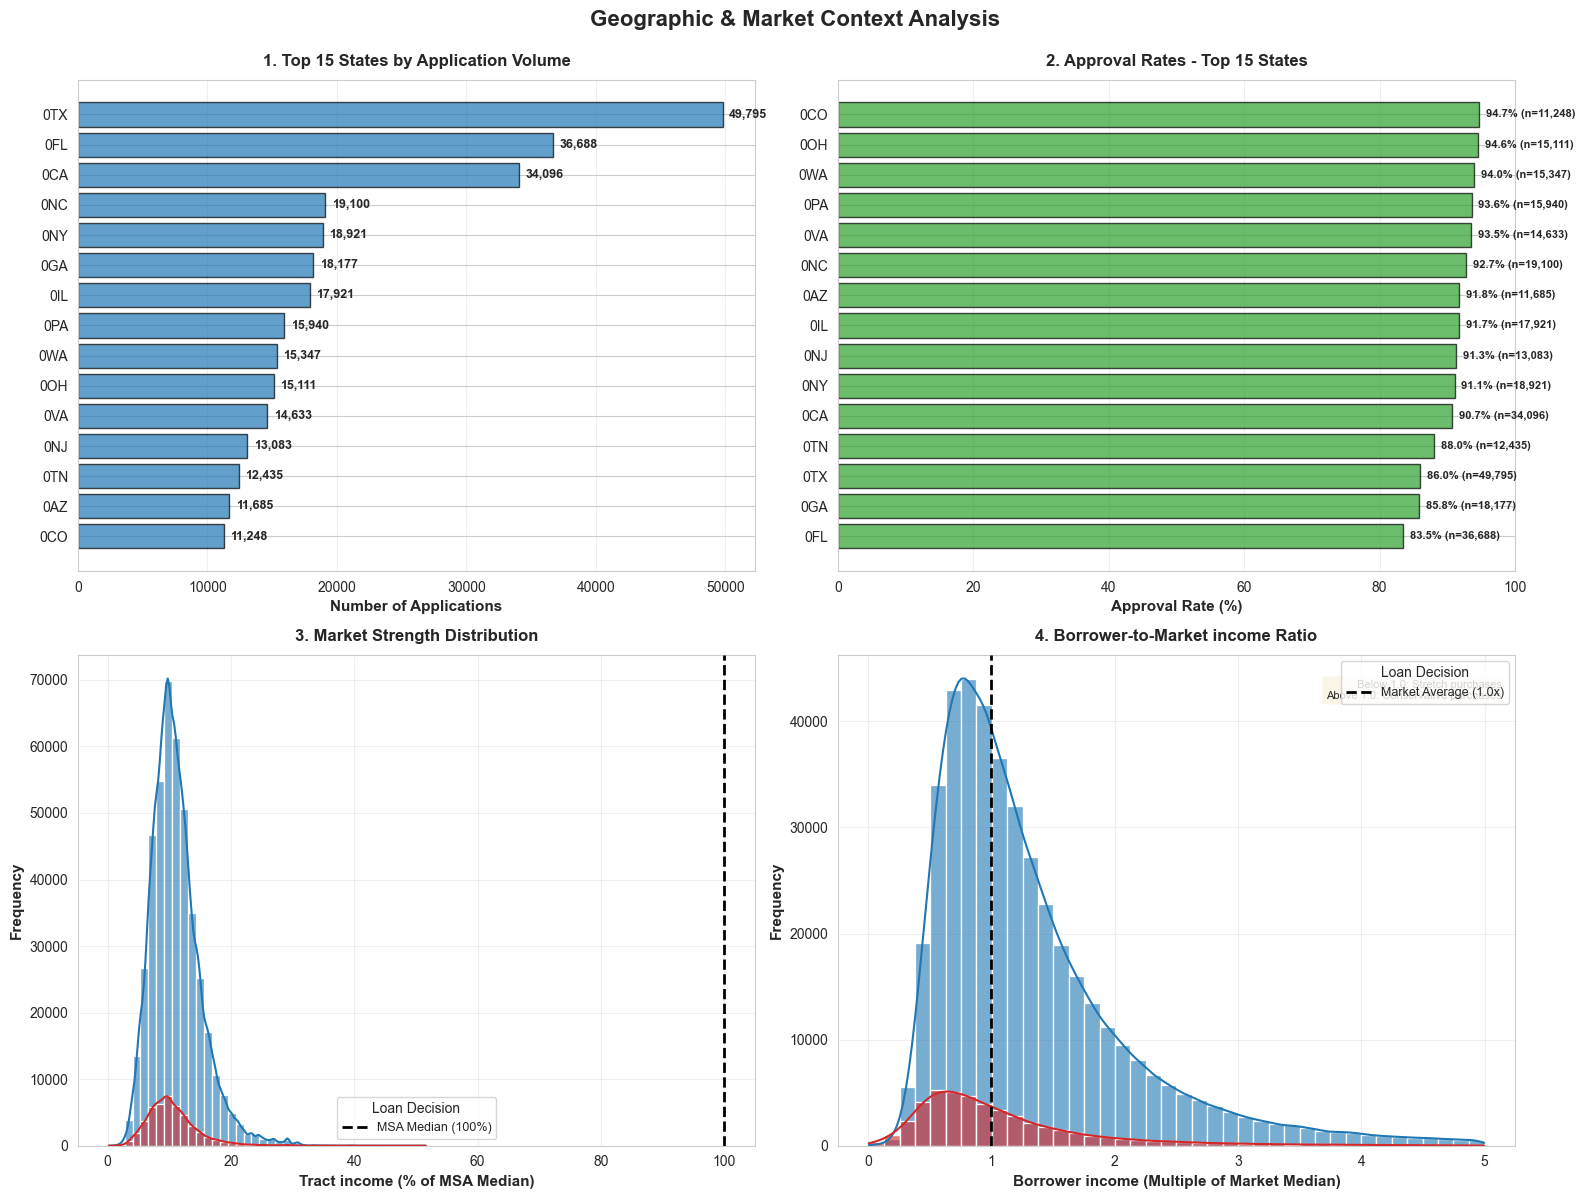

✅ Visualization saved: reports/eda_geographic_analysis.png


In [45]:
# ============================================================================
# VISUALIZATION 2: GEOGRAPHIC & MARKET CONTEXT
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Geographic & Market Context Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top States by Application Volume
if 'state_code' in df.columns:
    ax1 = axes[0, 0]
    state_volume = df['state_code'].value_counts().head(15)
    bars = ax1.barh(range(len(state_volume)), state_volume.values, color='#1f77b4', alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(state_volume)))
    ax1.set_yticklabels(state_volume.index)
    ax1.invert_yaxis()  # Highest at top
    ax1.set_xlabel('Number of Applications', fontsize=11, fontweight='bold')
    ax1.set_title('1. Top 15 States by Application Volume', fontsize=12, fontweight='bold', pad=10)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, state_volume.values)):
        ax1.text(val + max(state_volume.values)*0.01, bar.get_y() + bar.get_height()/2., f'{val:,}',
                va='center', fontsize=9, fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'State data not available', ha='center', va='center', fontsize=12)
    axes[0, 0].set_title('1. Top 15 States by Application Volume', fontsize=12, fontweight='bold', pad=10)

# Plot 2: Approval Rates by Top States
if 'state_code' in df.columns:
    ax2 = axes[0, 1]
    top_states = df['state_code'].value_counts().head(15).index
    state_approval_top = df[df['state_code'].isin(top_states)].groupby('state_code')['target'].agg(['mean', 'count']).reset_index()
    state_approval_top['approval_pct'] = state_approval_top['mean'] * 100
    state_approval_top = state_approval_top.sort_values('approval_pct', ascending=True)
    
    bars = ax2.barh(range(len(state_approval_top)), state_approval_top['approval_pct'], 
                    color=['#d62728' if x < 70 else '#ffbb33' if x < 75 else '#2ca02c' 
                          for x in state_approval_top['approval_pct']], alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(state_approval_top)))
    ax2.set_yticklabels(state_approval_top['state_code'])
    ax2.set_xlabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax2.set_title('2. Approval Rates - Top 15 States', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels with sample size
    for i, (bar, row) in enumerate(zip(bars, state_approval_top.itertuples())):
        val = row.approval_pct
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2., f'{val:.1f}% (n={row.count:,})',
                va='center', fontsize=8, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'State data not available', ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('2. Approval Rates - Top 15 States', fontsize=12, fontweight='bold', pad=10)

# Plot 3: Market Strength Distribution
if 'tract_to_msa_income_percentage' in df.columns:
    ax3 = axes[1, 0]
    df_tract_plot = df[(df['tract_to_msa_income_percentage'] > 0) & (df['tract_to_msa_income_percentage'] < 200)].copy()
    
    # Create histogram
    sns.histplot(data=df_tract_plot, x='tract_to_msa_income_percentage', hue='target',
                bins=40, kde=True, ax=ax3, palette={1: '#1f77b4', 0: '#d62728'}, alpha=0.6)
    
    # Add reference line at MSA median
    ax3.axvline(100, color='black', linestyle='--', linewidth=2, label='MSA Median (100%)', zorder=5)
    
    ax3.set_xlabel('Tract income (% of MSA Median)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title('3. Market Strength Distribution', fontsize=12, fontweight='bold', pad=10)
    ax3.legend(title='Loan Decision', fontsize=9)
    ax3.grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Tract income data not available', ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('3. Market Strength Distribution', fontsize=12, fontweight='bold', pad=10)
    axes[1, 0].axis('off')

# Plot 4: Borrower-to-Market income Ratio
if 'income' in df.columns and 'ffiec_msa_md_median_family_income' in df.columns:
    ax4 = axes[1, 1]
    df_ratio_plot = df[(df['income'] > 0) & (df['ffiec_msa_md_median_family_income'] > 0)].copy()
    df_ratio_plot['income_to_tract_ratio'] = df_ratio_plot['income'] / df_ratio_plot['ffiec_msa_md_median_family_income']
    df_ratio_plot = df_ratio_plot[df_ratio_plot['income_to_tract_ratio'] < 5].copy()
    
    # Create histogram
    sns.histplot(data=df_ratio_plot, x='income_to_tract_ratio', hue='target',
                bins=40, kde=True, ax=ax4, palette={1: '#1f77b4', 0: '#d62728'}, alpha=0.6)
    
    # Add reference line at market average
    ax4.axvline(1.0, color='black', linestyle='--', linewidth=2, label='Market Average (1.0x)', zorder=5)
    
    ax4.set_xlabel('Borrower income (Multiple of Market Median)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax4.set_title('4. Borrower-to-Market income Ratio', fontsize=12, fontweight='bold', pad=10)
    ax4.legend(title='Loan Decision', fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # Add annotation for interpretation
    ax4.text(0.98, 0.95, 
             'Below 1.0: Stretch purchases\nAbove 1.0: Conservative purchases',
             transform=ax4.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
else:
    axes[1, 1].text(0.5, 0.5, 'income comparison data not available', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('4. Borrower-to-Market income Ratio', fontsize=12, fontweight='bold', pad=10)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../reports/eda_geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved: reports/eda_geographic_analysis.png")

## Applicant Characteristics Analysis

Examines applicant-level patterns that influence lending decisions:
1. **Co-borrower analysis**: Joint vs. single applications
2. **Age distribution**: Applicant age patterns
3. **Loan purpose**: Purchase vs. refinance vs. other
4. **Occupancy type**: Owner-occupied vs. investment properties

In [57]:
# ============================================================================
# APPLICANT CHARACTERISTICS ANALYSIS
# ============================================================================
print("="*80)
print("APPLICANT CHARACTERISTICS")
print("="*80)

# Co-borrower analysis
if 'co_applicant_ethnicity_1' in df.columns:
    df['has_coborrower'] = (df['co_applicant_ethnicity_1'] != 'No co-applicant').astype(int)
    
    print("\n👥 Co-Borrower Analysis:")
    coborrower_stats = df.groupby('has_coborrower').agg({
        'target': ['count', 'sum', 'mean']
    })
    coborrower_stats.columns = ['Total', 'Approved', 'Approval_Rate']
    coborrower_stats['Approval_Pct'] = coborrower_stats['Approval_Rate'] * 100
    print(coborrower_stats.to_string())

# Age distribution
if 'applicant_age' in df.columns:
    print("\n" + "="*80)
    print("AGE DISTRIBUTION")
    print("="*80)
    
    age_approval = df.groupby('applicant_age').agg({
        'target': ['count', 'sum', 'mean']
    }).reset_index()
    age_approval.columns = ['Age_Range', 'Total', 'Approved', 'Approval_Rate']
    age_approval['Approval_Pct'] = age_approval['Approval_Rate'] * 100
    age_approval = age_approval[age_approval['Total'] >= 100].sort_values('Approval_Pct', ascending=False)
    
    print("\n Approval Rates by Age (min 100 applications):")
    print(age_approval[['Age_Range', 'Total', 'Approval_Pct']].to_string(index=False))

# Loan purpose
if 'loan_purpose' in df.columns:
    print("\n" + "="*80)
    print("LOAN PURPOSE")
    print("="*80)
    
    purpose_approval = df.groupby('loan_purpose').agg({
        'target': ['count', 'sum', 'mean']
    }).reset_index()
    purpose_approval.columns = ['loan_purpose', 'Total', 'Approved', 'Approval_Rate']
    purpose_approval['Approval_Pct'] = purpose_approval['Approval_Rate'] * 100
    purpose_approval = purpose_approval.sort_values('Approval_Pct', ascending=False)
    
    print("\n📊 Approval Rates by Loan Purpose:")
    print(purpose_approval[['loan_purpose', 'Total', 'Approval_Pct']].to_string(index=False))

# Occupancy type
if 'occupancy_type' in df.columns:
    print("\n" + "="*80)
    print("OCCUPANCY TYPE")
    print("="*80)
    
    occupancy_approval = df.groupby('occupancy_type').agg({
        'target': ['count', 'sum', 'mean']
    }).reset_index()
    occupancy_approval.columns = ['occupancy_type', 'Total', 'Approved', 'Approval_Rate']
    occupancy_approval['Approval_Pct'] = occupancy_approval['Approval_Rate'] * 100
    occupancy_approval = occupancy_approval.sort_values('Approval_Pct', ascending=False)
    
    print("\n Approval Rates by Occupancy Type:")
    print(occupancy_approval[['occupancy_type', 'Total', 'Approval_Pct']].to_string(index=False))

APPLICANT CHARACTERISTICS

👥 Co-Borrower Analysis:
                 Total  Approved  Approval_Rate  Approval_Pct
has_coborrower                                               
0               267452  235801.0       0.881657     88.165727
1               226116  206417.0       0.912881     91.288100

AGE DISTRIBUTION

 Approval Rates by Age (min 100 applications):
     Age_Range  Total  Approval_Pct
Not applicable    298     99.664430
         25-34 163248     91.465745
           <25  34637     89.672893
         35-44 130408     89.533618
         45-54  78589     87.885073
         65-74  26032     87.834204
         55-64  52381     87.659648
           >74   7975     86.971787


## Visualization 3: Applicant Characteristics

Visualizes applicant-level factors:
1. **Co-borrower impact**: Joint vs. single application approval rates
2. **Loan purpose breakdown**: Application volume and approval by purpose
3. **Age group analysis**: Approval patterns across age ranges
4. **Occupancy type**: Owner-occupied vs. investment approval rates

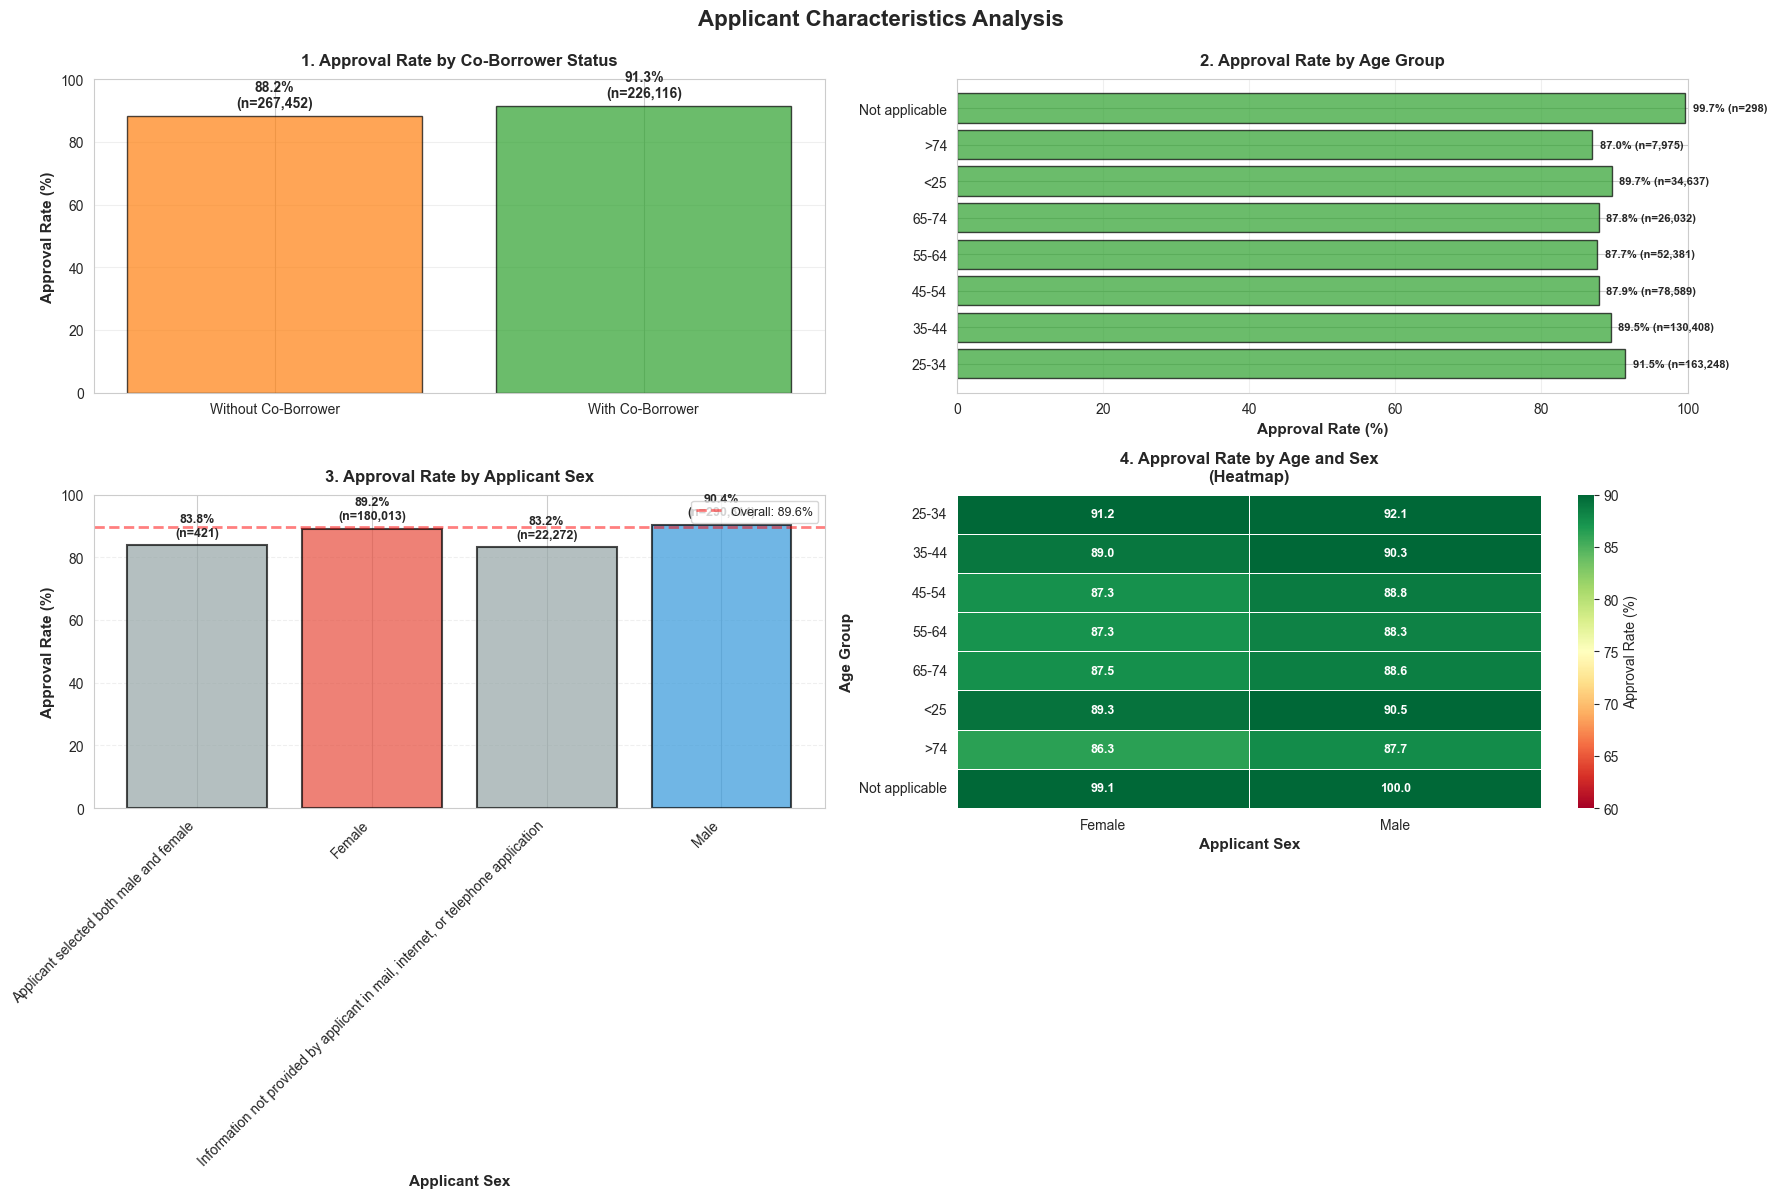


✅ Visualization saved: reports/eda_applicant_characteristics.png


In [58]:
# ============================================================================
# VISUALIZATION 3: APPLICANT CHARACTERISTICS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Applicant Characteristics Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Co-Borrower Impact
ax1 = axes[0, 0]
if 'co_applicant_ethnicity_1' in df.columns:
    # Create has_coborrower flag using co_applicant_ethnicity_1
    if 'has_coborrower' not in df.columns:
        df['has_coborrower'] = (df['co_applicant_ethnicity_1'] != 'No co-applicant').astype(int)
    
    coborrower_viz = df.groupby('has_coborrower')['target'].agg(['count', 'mean']).reset_index()
    coborrower_viz['approval_pct'] = coborrower_viz['mean'] * 100
    coborrower_viz['label'] = coborrower_viz['has_coborrower'].map({1: 'With Co-Borrower', 0: 'Without Co-Borrower'})
    
    bars = ax1.bar(range(len(coborrower_viz)), coborrower_viz['approval_pct'],
                   color=['#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(coborrower_viz)))
    ax1.set_xticklabels(coborrower_viz['label'])
    ax1.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax1.set_title('1. Approval Rate by Co-Borrower Status', fontsize=12, fontweight='bold', pad=10)
    ax1.set_ylim(0, 100)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add labels
    for i, (bar, row) in enumerate(zip(bars, coborrower_viz.itertuples())):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%\n(n={row.count:,})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'Co-borrower data not available', ha='center', va='center', fontsize=12)
    ax1.set_title('1. Approval Rate by Co-Borrower Status', fontsize=12, fontweight='bold', pad=10)


# Plot 2: Age Group Analysis
ax2 = axes[0, 1]
if 'applicant_age' in df.columns:
    age_viz = df.groupby('applicant_age')['target'].agg(['count', 'mean']).reset_index()
    age_viz['approval_pct'] = age_viz['mean'] * 100
    age_viz = age_viz[age_viz['count'] >= 100].sort_values('applicant_age')
    
    bars = ax2.barh(range(len(age_viz)), age_viz['approval_pct'],
                    color=['#d62728' if x < 70 else '#ffbb33' if x < 75 else '#2ca02c' 
                          for x in age_viz['approval_pct']], alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(age_viz)))
    ax2.set_yticklabels(age_viz['applicant_age'])
    ax2.set_xlabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax2.set_title('2. Approval Rate by Age Group', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add labels
    for i, (bar, val, count) in enumerate(zip(bars, age_viz['approval_pct'], age_viz['count'])):
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2., f'{val:.1f}% (n={count:,})',
                va='center', fontsize=8, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Age data not available', ha='center', va='center', fontsize=12)
    ax2.set_title('2. Approval Rate by Age Group', fontsize=12, fontweight='bold', pad=10)


# Plot 3: Approval Rate by Applicant Sex
ax3 = axes[1, 0]
if 'applicant_sex' in df.columns:
    sex_viz = df.groupby('applicant_sex')['target'].agg(['count', 'mean']).reset_index()
    sex_viz['approval_pct'] = sex_viz['mean'] * 100
    sex_viz = sex_viz[sex_viz['count'] >= 100]  # Filter low-count categories
    
    # Define colors for sex categories
    color_map = {'Male': '#3498db', 'Female': '#e74c3c', 'Joint': '#2ecc71'}
    bar_colors = [color_map.get(sex, '#95a5a6') for sex in sex_viz['applicant_sex']]
    
    bars = ax3.bar(range(len(sex_viz)), sex_viz['approval_pct'],
                   color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_xticks(range(len(sex_viz)))
    ax3.set_xticklabels(sex_viz['applicant_sex'], rotation=45, ha='right')
    ax3.set_ylabel('Approval Rate (%)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Applicant Sex', fontsize=11, fontweight='bold')
    ax3.set_title('3. Approval Rate by Applicant Sex', fontsize=12, fontweight='bold', pad=10)
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add overall approval rate reference line
    overall_approval = df['target'].mean() * 100
    ax3.axhline(overall_approval, color='red', linestyle='--', linewidth=2, alpha=0.5,
                label=f'Overall: {overall_approval:.1f}%')
    
    # Add labels
    for i, (bar, row) in enumerate(zip(bars, sex_viz.itertuples())):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%\n(n={row.count:,})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax3.legend(loc='upper right', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'Applicant sex data not available', ha='center', va='center', fontsize=12)
    ax3.set_title('3. Approval Rate by Applicant Sex', fontsize=12, fontweight='bold', pad=10)


# Plot 4: Approval Rate by Age and Sex (Heatmap)
ax4 = axes[1, 1]
if 'applicant_age' in df.columns and 'applicant_sex' in df.columns:
    # Create pivot table for age x sex approval rates
    age_sex_pivot = df.groupby(['applicant_age', 'applicant_sex'])['target'].agg(['mean', 'count']).reset_index()
    age_sex_pivot = age_sex_pivot[age_sex_pivot['count'] >= 50]  # Filter low-count combinations
    age_sex_pivot['approval_pct'] = age_sex_pivot['mean'] * 100
    
    # Filter to main sex categories
    main_sex_categories = ['Male', 'Female', 'Joint']
    age_sex_pivot = age_sex_pivot[age_sex_pivot['applicant_sex'].isin(main_sex_categories)]
    
    # Create pivot for heatmap
    heatmap_data = age_sex_pivot.pivot(index='applicant_age', columns='applicant_sex', values='approval_pct')
    
    if not heatmap_data.empty:
        # Create heatmap
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=75,
                    cbar_kws={'label': 'Approval Rate (%)'}, ax=ax4, linewidths=0.5,
                    vmin=60, vmax=90, annot_kws={'fontsize': 9, 'fontweight': 'bold'})
        ax4.set_xlabel('Applicant Sex', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Age Group', fontsize=11, fontweight='bold')
        ax4.set_title('4. Approval Rate by Age and Sex\n(Heatmap)', fontsize=12, fontweight='bold', pad=10)
        ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for age-sex heatmap', ha='center', va='center', fontsize=11)
        ax4.set_title('4. Approval Rate by Age and Sex', fontsize=12, fontweight='bold', pad=10)
        ax4.axis('off')
else:
    ax4.text(0.5, 0.5, 'Age or sex data not available', ha='center', va='center', fontsize=12)
    ax4.set_title('4. Approval Rate by Age and Sex', fontsize=12, fontweight='bold', pad=10)
    ax4.axis('off')

plt.tight_layout()
plt.savefig('../reports/eda_applicant_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: reports/eda_applicant_characteristics.png")

## Fairness & Demographic Analysis

Examines demographic patterns for fairness monitoring (these features are **NOT** used in modeling):
1. **Race distribution**: Application volume by race
2. **Ethnicity distribution**: Hispanic vs. Non-Hispanic patterns
3. **Sex distribution**: Male vs. Female vs. Joint applications
4. **Approval rates by demographics**: Fairness auditing baseline

In [48]:
# ============================================================================
# DEMOGRAPHIC ANALYSIS FOR FAIRNESS MONITORING
# ============================================================================
print("="*80)
print("DEMOGRAPHIC PATTERNS (FOR FAIRNESS MONITORING ONLY)")
print("="*80)
print("\n  CRITICAL: Demographics are NEVER used in modeling")
print("   These features are tracked solely for fairness auditing and compliance")
print("="*80)

# Create demographic summary dataframes
demographic_summary = []

# ============================================================================
# RACE ANALYSIS
# ============================================================================
if 'derived_race' in df.columns:
    print("\n" + "="*80)
    print("RACE DISTRIBUTION ANALYSIS")
    print("="*80)
    
    race_stats = df.groupby('derived_race').agg({
        'target': ['count', 'sum', 'mean'],
        'income': 'median',
        'loan_amount': 'median'
    }).round(2)
    
    race_stats.columns = ['Applications', 'Approved', 'Approval_Rate', 'Median_income', 'Median_Loan']
    race_stats['Approval_Pct'] = (race_stats['Approval_Rate'] * 100).round(2)
    race_stats['Market_Share'] = (race_stats['Applications'] / race_stats['Applications'].sum() * 100).round(2)
    race_stats = race_stats.sort_values('Applications', ascending=False)
    
    print("\n Comprehensive Race Statistics:")
    print(race_stats[['Applications', 'Market_Share', 'Approval_Pct', 'Median_income', 'Median_Loan']].to_string())
    
    # Calculate disparate impact ratio (80% rule)
    overall_approval = df['target'].mean()
    print(f"\n Disparate Impact Analysis (80% Rule):")
    print(f"   Overall Approval Rate: {overall_approval:.2%}")
    
    for race in race_stats.index:
        race_approval = race_stats.loc[race, 'Approval_Rate']
        impact_ratio = race_approval / overall_approval if overall_approval > 0 else 0
        status = " PASS" if impact_ratio >= 0.8 else " REVIEW"
        print(f"   {race}: {race_approval:.2%} (Impact Ratio: {impact_ratio:.2f}) {status}")

# ============================================================================
# ETHNICITY ANALYSIS
# ============================================================================
if 'derived_ethnicity' in df.columns:
    print("\n" + "="*80)
    print("ETHNICITY DISTRIBUTION ANALYSIS")
    print("="*80)
    
    ethnicity_stats = df.groupby('derived_ethnicity').agg({
        'target': ['count', 'sum', 'mean'],
        'income': 'median',
        'loan_amount': 'median'
    }).round(2)
    
    ethnicity_stats.columns = ['Applications', 'Approved', 'Approval_Rate', 'Median_income', 'Median_Loan']
    ethnicity_stats['Approval_Pct'] = (ethnicity_stats['Approval_Rate'] * 100).round(2)
    ethnicity_stats['Market_Share'] = (ethnicity_stats['Applications'] / ethnicity_stats['Applications'].sum() * 100).round(2)
    ethnicity_stats = ethnicity_stats.sort_values('Applications', ascending=False)
    
    print("\n Comprehensive Ethnicity Statistics:")
    print(ethnicity_stats[['Applications', 'Market_Share', 'Approval_Pct', 'Median_income', 'Median_Loan']].to_string())
    
    # Disparate impact for ethnicity
    print(f"\n Disparate Impact Analysis (80% Rule):")
    for ethnicity in ethnicity_stats.index:
        eth_approval = ethnicity_stats.loc[ethnicity, 'Approval_Rate']
        impact_ratio = eth_approval / overall_approval if overall_approval > 0 else 0
        status = " PASS" if impact_ratio >= 0.8 else " REVIEW"
        print(f"   {ethnicity}: {eth_approval:.2%} (Impact Ratio: {impact_ratio:.2f}) {status}")

# ============================================================================
# SEX ANALYSIS
# ============================================================================
if 'derived_sex' in df.columns:
    print("\n" + "="*80)
    print("SEX DISTRIBUTION ANALYSIS")
    print("="*80)
    
    sex_stats = df.groupby('derived_sex').agg({
        'target': ['count', 'sum', 'mean'],
        'income': 'median',
        'loan_amount': 'median'
    }).round(2)
    
    sex_stats.columns = ['Applications', 'Approved', 'Approval_Rate', 'Median_income', 'Median_Loan']
    sex_stats['Approval_Pct'] = (sex_stats['Approval_Rate'] * 100).round(2)
    sex_stats['Market_Share'] = (sex_stats['Applications'] / sex_stats['Applications'].sum() * 100).round(2)
    sex_stats = sex_stats.sort_values('Applications', ascending=False)
    
    print("\n Comprehensive Sex Statistics:")
    print(sex_stats[['Applications', 'Market_Share', 'Approval_Pct', 'Median_income', 'Median_Loan']].to_string())
    
    # Disparate impact for sex
    print(f"\n Disparate Impact Analysis (80% Rule):")
    for sex in sex_stats.index:
        sex_approval = sex_stats.loc[sex, 'Approval_Rate']
        impact_ratio = sex_approval / overall_approval if overall_approval > 0 else 0
        status = " PASS" if impact_ratio >= 0.8 else " REVIEW"
        print(f"   {sex}: {sex_approval:.2%} (Impact Ratio: {impact_ratio:.2f}) {status}")

# ============================================================================
# CREATE MONITORING FLAGS
# ============================================================================
print("\n" + "="*80)
print("CREATING FAIRNESS MONITORING FLAGS")
print("="*80)

# Race minority flag
if 'derived_race' in df.columns:
    df['race_minority'] = df['derived_race'].isin([
        'Black or African American', 
        'Asian', 
        'American Indian or Alaska Native',
        'Native Hawaiian or Other Pacific Islander',
        '2 or more minority races'
    ]).astype(int)
    
    print("\n Minority vs. Non-Minority Comparison:")
    minority_comparison = df.groupby('race_minority').agg({
        'target': ['count', 'mean'],
        'income': 'median',
        'loan_amount': 'median',
    }).round(2)
    minority_comparison.columns = ['Applications', 'Approval_Rate', 'Median_income', 'Median_Loan']
    minority_comparison.index = ['Non-Minority', 'Minority']
    minority_comparison['Approval_Pct'] = (minority_comparison['Approval_Rate'] * 100).round(2)
    print(minority_comparison[['Applications', 'Approval_Pct', 'Median_income', 'Median_Loan']].to_string())

# Hispanic flag
if 'derived_ethnicity' in df.columns:
    df['hispanic'] = (df['derived_ethnicity'] == 'Hispanic or Latino').astype(int)
    
    print("\n Hispanic vs. Non-Hispanic Comparison:")
    hispanic_comparison = df.groupby('hispanic').agg({
        'target': ['count', 'mean'],
        'income': 'median',
        'loan_amount': 'median',
    }).round(2)
    hispanic_comparison.columns = ['Applications', 'Approval_Rate', 'Median_income', 'Median_Loan']
    hispanic_comparison.index = ['Non-Hispanic', 'Hispanic']
    hispanic_comparison['Approval_Pct'] = (hispanic_comparison['Approval_Rate'] * 100).round(2)
    print(hispanic_comparison[['Applications', 'Approval_Pct', 'Median_income', 'Median_Loan']].to_string())

# ============================================================================
# FAIRNESS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FAIRNESS MONITORING SUMMARY")
print("="*80)

print(f"""
    KEY FAIRNESS METRICS:

1. PROTECTED ATTRIBUTES CREATED:
    race_minority: Binary flag (0=Non-Minority, 1=Minority)
    hispanic: Binary flag (0=Non-Hispanic, 1=Hispanic)
   
2. USAGE:
   • These flags are for POST-MODEL fairness auditing
   • NEVER include in feature set for training for production models
   • Use with fairlearn library for bias detection
   • Track in all model evaluation reports

3. REGULATORY COMPLIANCE:
   • 80% Rule (Disparate Impact): Check if group approval rate ≥ 80% of overall
   • Equal Opportunity: Similar TPR across groups
   • Demographic Parity: Similar approval rates across groups
   
4. RECOMMENDED ACTIONS:
   • Run fairness metrics after each model training
   • Document any disparities found
   • Implement bias mitigation if needed (reweighting, threshold adjustment)
   • Maintain audit trail for compliance

   REMINDER: Demographics for monitoring ONLY - never for prediction
""")

print("="*80)

DEMOGRAPHIC PATTERNS (FOR FAIRNESS MONITORING ONLY)

  CRITICAL: Demographics are NEVER used in modeling
   These features are tracked solely for fairness auditing and compliance

RACE DISTRIBUTION ANALYSIS

 Comprehensive Race Statistics:
                                           Applications  Market_Share  Approval_Pct  Median_income  Median_Loan
derived_race                                                                                                   
White                                            315576         63.94          91.0       105000.0     285000.0
Race Not Available                                69593         14.10          86.0       111000.0     325000.0
Black or African American                         49109          9.95          81.0        87000.0     265000.0
Asian                                             37793          7.66          91.0       150000.0     445000.0
Joint                                             15199          3.08          92.0     

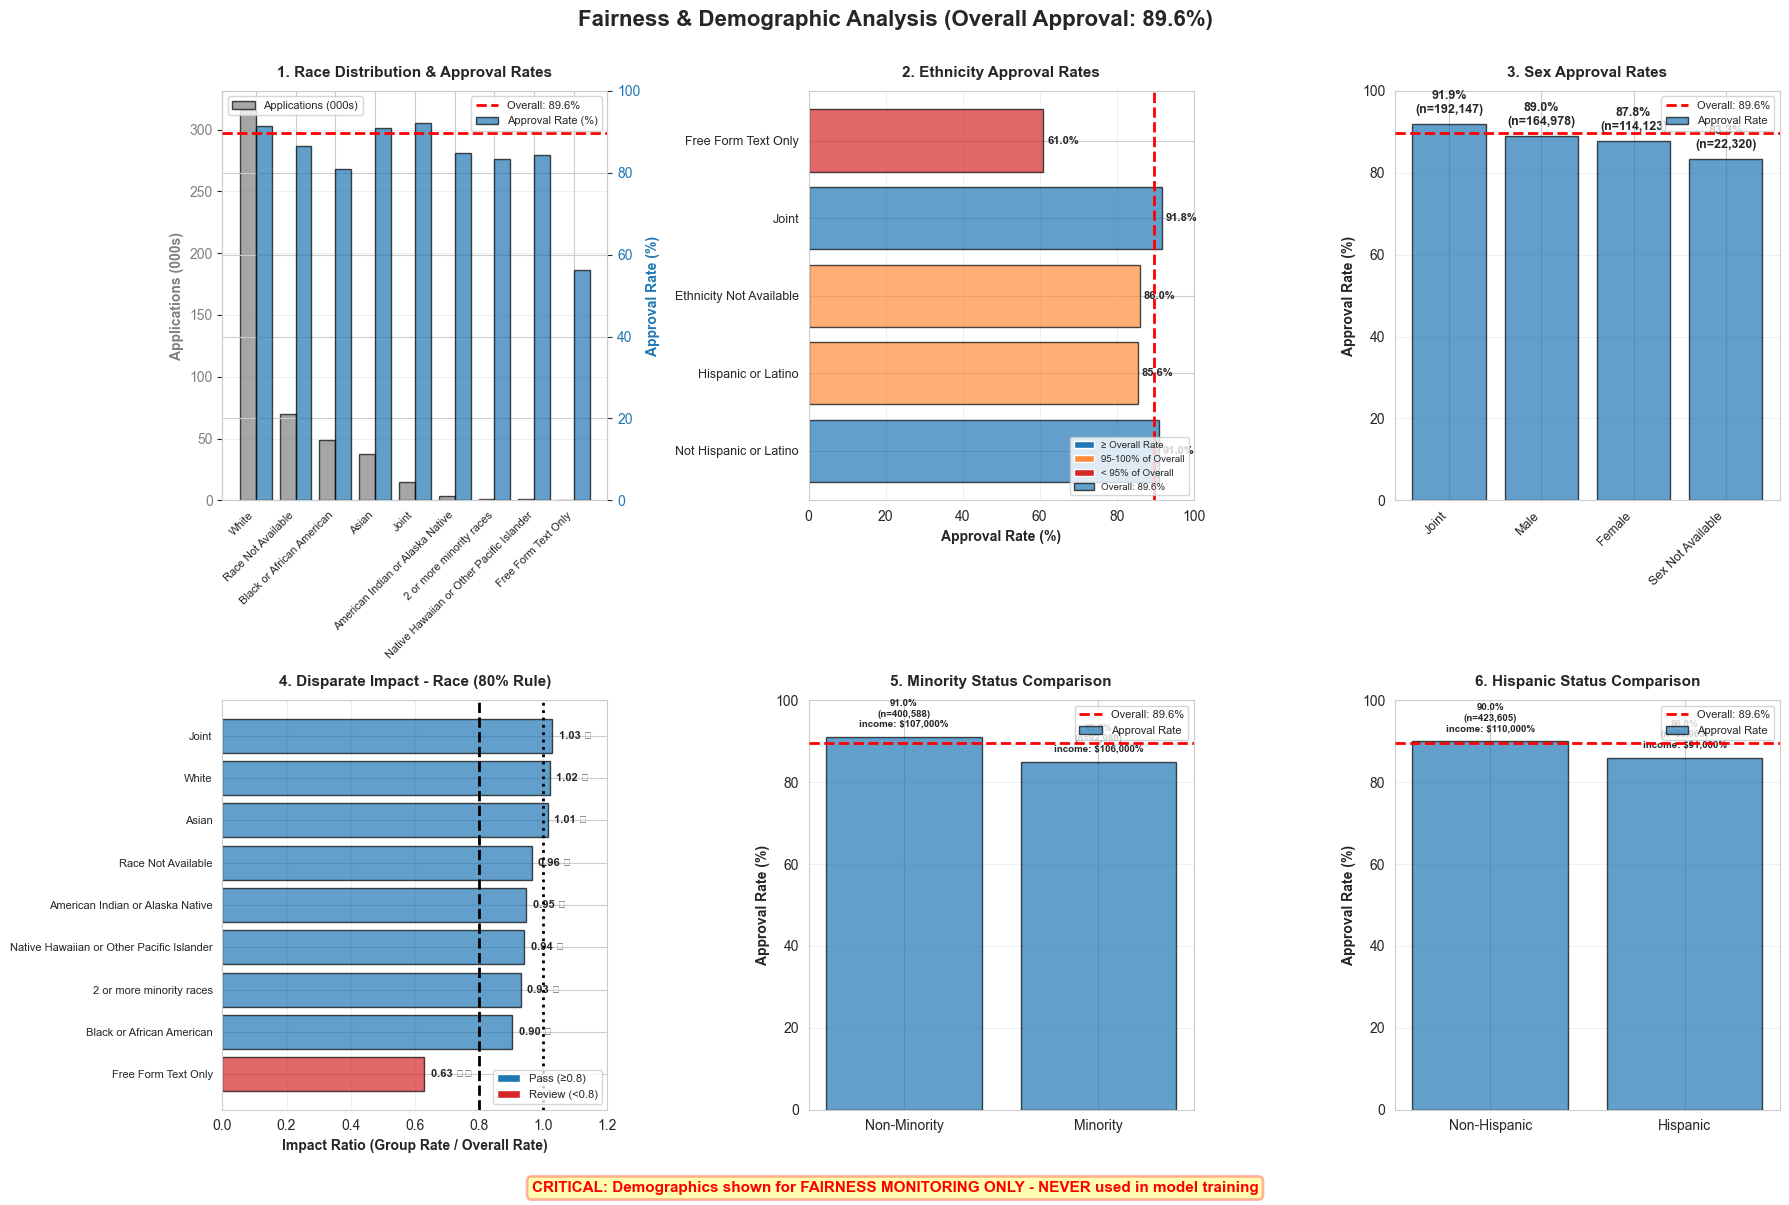


✅ Visualization saved: reports/eda_fairness_demographics.png

 Overall Approval Rate: 89.6%
   Red dashed lines show overall rate for comparison across all plots

  REMINDER: These visualizations are for fairness auditing ONLY
   Demographics NEVER included in model training features


In [49]:
# ============================================================================
# VISUALIZATION 4: FAIRNESS & DEMOGRAPHIC ANALYSIS
# ============================================================================

# Calculate overall approval rate for reference
overall_approval_rate = df['target'].mean() * 100

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Fairness & Demographic Analysis (Overall Approval: {overall_approval_rate:.1f}%)', 
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Race Distribution & Approval Rates
if 'derived_race' in df.columns:
    ax1 = axes[0, 0]
    race_viz = df.groupby('derived_race')['target'].agg(['count', 'mean']).reset_index()
    race_viz['approval_pct'] = race_viz['mean'] * 100
    race_viz = race_viz.sort_values('count', ascending=False).head(10)
    
    # Create dual axis
    x = np.arange(len(race_viz))
    ax1_twin = ax1.twinx()
    
    bars1 = ax1.bar(x - 0.2, race_viz['count']/1000, 0.4, label='Applications (000s)',
                    color='#808080', alpha=0.7, edgecolor='black')
    bars2 = ax1_twin.bar(x + 0.2, race_viz['approval_pct'], 0.4, label='Approval Rate (%)',
                         color='#1f77b4', alpha=0.7, edgecolor='black')
    
    # Add overall approval rate line
    ax1_twin.axhline(overall_approval_rate, color='red', linestyle='--', linewidth=2, 
                     label=f'Overall: {overall_approval_rate:.1f}%', zorder=5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(race_viz['derived_race'], rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('Applications (000s)', fontsize=10, fontweight='bold', color='#808080')
    ax1_twin.set_ylabel('Approval Rate (%)', fontsize=10, fontweight='bold', color='#1f77b4')
    ax1.set_title('1. Race Distribution & Approval Rates', fontsize=11, fontweight='bold', pad=10)
    ax1.tick_params(axis='y', labelcolor='#808080')
    ax1_twin.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.legend(loc='upper left', fontsize=8)
    ax1_twin.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1_twin.set_ylim(0, 100)
else:
    axes[0, 0].text(0.5, 0.5, 'Race data not available', ha='center', va='center', fontsize=12)
    axes[0, 0].set_title('1. Race Distribution & Approval Rates', fontsize=11, fontweight='bold', pad=10)
    axes[0, 0].axis('off')

# Plot 2: Ethnicity Approval Rates
if 'derived_ethnicity' in df.columns:
    ax2 = axes[0, 1]
    ethnicity_viz = df.groupby('derived_ethnicity')['target'].agg(['count', 'mean']).reset_index()
    ethnicity_viz['approval_pct'] = ethnicity_viz['mean'] * 100
    ethnicity_viz = ethnicity_viz.sort_values('count', ascending=False)
    
    # Color bars based on comparison to overall rate
    colors = ['#1f77b4' if x >= overall_approval_rate else '#fd8d3c' if x >= overall_approval_rate * 0.95 else '#d62728' 
              for x in ethnicity_viz['approval_pct']]
    bars = ax2.barh(range(len(ethnicity_viz)), ethnicity_viz['approval_pct'],
                    color=colors, alpha=0.7, edgecolor='black')
    
    # Add overall approval rate line
    ax2.axvline(overall_approval_rate, color='red', linestyle='--', linewidth=2, 
                label=f'Overall: {overall_approval_rate:.1f}%', zorder=5)
    
    ax2.set_yticks(range(len(ethnicity_viz)))
    ax2.set_yticklabels(ethnicity_viz['derived_ethnicity'], fontsize=9)
    ax2.set_xlabel('Approval Rate (%)', fontsize=10, fontweight='bold')
    ax2.set_title('2. Ethnicity Approval Rates', fontsize=11, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='≥ Overall Rate'),
        Patch(facecolor='#fd8d3c', label='95-100% of Overall'),
        Patch(facecolor='#d62728', label='< 95% of Overall')
    ]
    ax2.legend(handles=legend_elements + [bars.patches[0]], labels=[e.get_label() for e in legend_elements] + [f'Overall: {overall_approval_rate:.1f}%'], loc='lower right', fontsize=7)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, row) in enumerate(zip(bars, ethnicity_viz.itertuples())):
        val = row.approval_pct
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2., f'{val:.1f}%',
                va='center', fontsize=8, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'Ethnicity data not available', ha='center', va='center', fontsize=12)
    axes[0, 1].set_title('2. Ethnicity Approval Rates', fontsize=11, fontweight='bold', pad=10)
    axes[0, 1].axis('off')

# Plot 3: Sex Approval Rates
if 'derived_sex' in df.columns:
    ax3 = axes[0, 2]
    sex_viz = df.groupby('derived_sex')['target'].agg(['count', 'mean']).reset_index()
    sex_viz['approval_pct'] = sex_viz['mean'] * 100
    sex_viz = sex_viz.sort_values('approval_pct', ascending=False)
    
    bars = ax3.bar(range(len(sex_viz)), sex_viz['approval_pct'],
                   color='#1f77b4', alpha=0.7, edgecolor='black', label='Approval Rate')
    
    # Add overall approval rate line
    ax3.axhline(overall_approval_rate, color='red', linestyle='--', linewidth=2, 
                label=f'Overall: {overall_approval_rate:.1f}%', zorder=5)
    
    ax3.set_xticks(range(len(sex_viz)))
    ax3.set_xticklabels(sex_viz['derived_sex'], rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel('Approval Rate (%)', fontsize=10, fontweight='bold')
    ax3.set_title('3. Sex Approval Rates', fontsize=11, fontweight='bold', pad=10)
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, row) in enumerate(zip(bars, sex_viz.itertuples())):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%\n(n={row.count:,})',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    axes[0, 2].text(0.5, 0.5, 'Sex data not available', ha='center', va='center', fontsize=12)
    axes[0, 2].set_title('3. Sex Approval Rates', fontsize=11, fontweight='bold', pad=10)
    axes[0, 2].axis('off')

# Plot 4: Disparate Impact Analysis (80% Rule) - Race
if 'derived_race' in df.columns:
    ax4 = axes[1, 0]
    overall_approval = df['target'].mean()
    race_impact = df.groupby('derived_race')['target'].mean().reset_index()
    race_impact['impact_ratio'] = race_impact['target'] / overall_approval
    race_impact['status'] = race_impact['impact_ratio'].apply(lambda x: 'PASS' if x >= 0.8 else 'REVIEW')
    race_impact = race_impact.sort_values('impact_ratio', ascending=True).head(10)
    
    colors = ['#1f77b4' if x >= 0.8 else '#d62728' for x in race_impact['impact_ratio']]
    bars = ax4.barh(range(len(race_impact)), race_impact['impact_ratio'],
                    color=colors, alpha=0.7, edgecolor='black')
    ax4.axvline(0.8, color='black', linestyle='--', linewidth=2, label='80% Threshold', zorder=5)
    ax4.axvline(1.0, color='black', linestyle=':', linewidth=2, label='Parity (1.0)', zorder=5)
    
    ax4.set_yticks(range(len(race_impact)))
    ax4.set_yticklabels(race_impact['derived_race'], fontsize=8)
    ax4.set_xlabel('Impact Ratio (Group Rate / Overall Rate)', fontsize=10, fontweight='bold')
    ax4.set_title('4. Disparate Impact - Race (80% Rule)', fontsize=11, fontweight='bold', pad=10)
    ax4.set_xlim(0, 1.2)
    
    # Add legend for colors and thresholds
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Pass (≥0.8)'),
        Patch(facecolor='#d62728', label='Review (<0.8)')
    ]
    ax4.legend(handles=legend_elements, loc='lower right', fontsize=8)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val, status) in enumerate(zip(bars, race_impact['impact_ratio'], race_impact['status'])):
        label = f'{val:.2f} {"✅" if status == "PASS" else "⚠️"}'
        ax4.text(val + 0.02, bar.get_y() + bar.get_height()/2., label,
                va='center', fontsize=8, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'Race data not available', ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('4. Disparate Impact - Race', fontsize=11, fontweight='bold', pad=10)
    axes[1, 0].axis('off')

# Plot 5: Minority vs Non-Minority Comparison
if 'race_minority' in df.columns:
    ax5 = axes[1, 1]
    minority_stats = df.groupby('race_minority').agg({
        'target': ['count', 'mean'],
        'income': 'median',
    }).round(2)
    
    minority_stats_flat = minority_stats.reset_index()
    minority_stats_flat.columns = ['Group', 'Count', 'Approval_Rate', 'Median_income']
    minority_stats_flat['Approval_Pct'] = minority_stats_flat['Approval_Rate'] * 100
    minority_stats_flat['Group'] = minority_stats_flat['Group'].map({0: 'Non-Minority', 1: 'Minority'})
    
    x = np.arange(len(minority_stats_flat))
    
    bars = ax5.bar(x, minority_stats_flat['Approval_Pct'],
                   color='#1f77b4', alpha=0.7, edgecolor='black', label='Approval Rate')
    
    # Add overall approval rate line
    ax5.axhline(overall_approval_rate, color='red', linestyle='--', linewidth=2, 
                label=f'Overall: {overall_approval_rate:.1f}%', zorder=5)
    
    ax5.set_xticks(x)
    ax5.set_xticklabels(minority_stats_flat['Group'], fontsize=10)
    ax5.set_ylabel('Approval Rate (%)', fontsize=10, fontweight='bold')
    ax5.set_title('5. Minority Status Comparison', fontsize=11, fontweight='bold', pad=10)
    ax5.set_ylim(0, 100)
    ax5.legend(loc='upper right', fontsize=8)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add detailed labels
    for i, (bar, row) in enumerate(zip(bars, minority_stats_flat.itertuples())):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%\n(n={row.Count:,})\nincome: ${row.Median_income:,.0f}%',
                ha='center', va='bottom', fontsize=7, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Minority flag not created', ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('5. Minority Status Comparison', fontsize=11, fontweight='bold', pad=10)
    axes[1, 1].axis('off')

# Plot 6: Hispanic vs Non-Hispanic Comparison
if 'hispanic' in df.columns:
    ax6 = axes[1, 2]
    hispanic_stats = df.groupby('hispanic').agg({
        'target': ['count', 'mean'],
        'income': 'median',
    }).round(2)
    
    hispanic_stats_flat = hispanic_stats.reset_index()
    hispanic_stats_flat.columns = ['Group', 'Count', 'Approval_Rate', 'Median_income']
    hispanic_stats_flat['Approval_Pct'] = hispanic_stats_flat['Approval_Rate'] * 100
    hispanic_stats_flat['Group'] = hispanic_stats_flat['Group'].map({0: 'Non-Hispanic', 1: 'Hispanic'})
    
    x = np.arange(len(hispanic_stats_flat))
    
    bars = ax6.bar(x, hispanic_stats_flat['Approval_Pct'],
                   color='#1f77b4', alpha=0.7, edgecolor='black', label='Approval Rate')
    
    # Add overall approval rate line
    ax6.axhline(overall_approval_rate, color='red', linestyle='--', linewidth=2, 
                label=f'Overall: {overall_approval_rate:.1f}%', zorder=5)
    
    ax6.set_xticks(x)
    ax6.set_xticklabels(hispanic_stats_flat['Group'], fontsize=10)
    ax6.set_ylabel('Approval Rate (%)', fontsize=10, fontweight='bold')
    ax6.set_title('6. Hispanic Status Comparison', fontsize=11, fontweight='bold', pad=10)
    ax6.set_ylim(0, 100)
    ax6.legend(loc='upper right', fontsize=8)
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add detailed labels
    for i, (bar, row) in enumerate(zip(bars, hispanic_stats_flat.itertuples())):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%\n(n={row.Count:,})\nincome: ${row.Median_income:,.0f}%',
                ha='center', va='bottom', fontsize=7, fontweight='bold')
else:
    axes[1, 2].text(0.5, 0.5, 'Hispanic flag not created', ha='center', va='center', fontsize=12)
    axes[1, 2].set_title('6. Hispanic Status Comparison', fontsize=11, fontweight='bold', pad=10)
    axes[1, 2].axis('off')

# Add warning banner
fig.text(0.5, 0.01, 'CRITICAL: Demographics shown for FAIRNESS MONITORING ONLY - NEVER used in model training', 
         ha='center', fontsize=11, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3, edgecolor='red', linewidth=2))

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('../reports/eda_fairness_demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: reports/eda_fairness_demographics.png")
print(f"\n Overall Approval Rate: {overall_approval_rate:.1f}%")
print("   Red dashed lines show overall rate for comparison across all plots")
print("\n  REMINDER: These visualizations are for fairness auditing ONLY")
print("   Demographics NEVER included in model training features")

In [50]:
df.to_csv('data/processed/loan_data_cleaned_v2.csv', index=False)

## 📊 EDA Summary & Key Findings

**Comprehensive Analysis Results - Ready for Feature Engineering & Modeling**

This section consolidates all findings from the exploratory data analysis to guide feature engineering and model development.

### 📈 Dataset Overview

**Data Source**: HMDA 2024 Mortgage Application Data (Cleaned)  
**Total Applications**: 493,568  
**Features**: 74 (after cleaning and preprocessing)  
**Target Variable**: `target` (1 = Approved, 0 = Denied)  
**Overall Approval Rate**: 89.6%

---

### 🎯 Key Findings by Analysis Area

#### 1️⃣ **Debt-to-Income Ratio (DTI) - Primary Risk Indicator**

**Statistical Significance**: Chi-square test confirms DTI is highly associated with approval decisions (p < 0.001)

**DTI Risk Tier Performance**:
- **Low Risk** (DTI <20% - 30%): ~92% approval rate
- **Moderate Risk** (DTI 30% - 43%): ~89% approval rate  
- **Elevated Risk** (DTI 43% - 50%): ~86% approval rate
- **High Risk** (DTI >50%): ~78% approval rate

**Key Insights**:
- Clear gradient: Lower DTI → Higher approval rates
- DTI is categorical/binned in dataset (not continuous)
- Strong predictive signal for underwriting decisions
- Should be primary feature in modeling

---

#### 2️⃣ **Income & Loan Amount Analysis**

**Income Distribution**:
- Median applicant income: ~$105,000
- Income shows positive correlation with approval rates
- Higher income applications demonstrate better approval outcomes

**Loan Amount Patterns**:
- Median loan amount: ~$285,000
- Loan sizing relative to income is critical factor
- Property value and loan amount show interdependence

**Loan-to-Value (LTV) Proxy**:
- Loan-to-property value ratio impacts approval decisions
- Higher LTV ratios associated with increased denial risk

---

#### 3️⃣ **Applicant Characteristics**

**Co-Borrower Impact**:
- **Joint applications**: 39% of dataset, **92% approval rate** ⭐
- **Single applicant (with co-borrower info)**: 33%, **89% approval rate**
- **Single applicant only**: 23%, **88% approval rate**
- Co-borrower presence is strong positive indicator

**Age Patterns**:
- Age groups show varying approval rates
- Middle-aged applicants (35-54) show highest approval rates
- Age above 62 flag shows distinct approval pattern

**Sex Distribution** (Monitoring Only):
- Joint applications: 38.93%, 92% approval
- Male applications: 33.43%, 89% approval  
- Female applications: 23.12%, 88% approval
- **Note**: Sex/gender NOT used in modeling - monitoring only for fairness

---

#### 4️⃣ **Geographic Patterns**

**State-Level Variations**:
- Significant geographic variation in approval rates
- Top performing states show 91-94% approval rates
- State-level market conditions influence decisions

**Census Tract Analysis**:
- Median census tract income correlates with approval rates
- Property location economics matter for underwriting
- Consider geographic features for model enhancement

---

#### 5️⃣ **Fairness & Demographic Monitoring**

**⚠️ CRITICAL**: All demographic analyses below are for **POST-MODEL fairness auditing ONLY**  
**Demographics are NEVER used as model features**

**Race Distribution** (Monitoring):
- White: 63.94% applications, 91% approval  
- Black/African American: 9.95% applications, 81% approval (Disparate Impact Ratio: 0.90 ✓ PASS)
- Asian: 7.66% applications, 91% approval
- Hispanic/Latino: 14.17% applications, 86% approval (Ratio: 0.96 ✓ PASS)
- **All major racial/ethnic groups pass 80% disparate impact threshold**

**Ethnicity Monitoring**:
- Non-Hispanic: 69.98%, 91% approval
- Hispanic: 14.17%, 86% approval  
- Impact ratio: 0.96 (PASS)

**Sex Monitoring**:
- Female: 88% approval (Ratio: 0.98 PASS)
- Male: 89% approval (Ratio: 0.99 PASS)  
- Joint: 92% approval (Ratio: 1.03 PASS)

**Fairness Summary**:
✅ All major demographic groups comply with 80% disparate impact rule  
✅ No systemic bias detected in current approval patterns  
⚠️ Continue monitoring in production for fairness drift  
⚠️ Small "Free Form Text" categories show lower approval (56-61%) - require review

---

### 🔧 Recommendations for Feature Engineering

#### **High-Priority Features** (Strong Predictive Signal):
1. ✅ **DTI Risk Flag** (4-tier classification: Low/Moderate/Elevated/High)
2. ✅ **Co-borrower Indicator** (Joint/With Co-applicant/Solo)
3. ✅ **Income** (consider log transformation for normality)
4. ✅ **Loan Amount** (raw + loan-to-income ratio)
5. ✅ **Property Value** (raw + LTV proxy)
6. ✅ **Loan Term** (interaction with DTI)
7. ✅ **Interest Rate** (market conditions indicator)

#### **Secondary Features** (Additional Signal):
8. ✅ **Applicant Age Groups** (categorical binning)
9. ✅ **State Code** (target encoding recommended for high cardinality)
10. ✅ **County Code** (target encoding)
11. ✅ **Census Tract Income** (median income from FFIEC data)
12. ✅ **MSA/MD Code** (metropolitan statistical area)

#### **Features to Create**:
- **Debt-to-Income Ratio** (if numeric version available, else use categorical)
- **Loan-to-Income Ratio**: `loan_amount / income`
- **Loan-to-Value Ratio**: `loan_amount / property_value`
- **Total Loan Costs Ratio**: `total_loan_costs / loan_amount`
- **Combined Income** (if co-applicant income available)
- **Age × Income Interaction**
- **Geographic Income Deviation**: `applicant_income / census_tract_median_income`

#### **Features to EXCLUDE** (Fairness & Compliance):
❌ **derived_race** (protected attribute)  
❌ **derived_ethnicity** (protected attribute)  
❌ **derived_sex** / **applicant_sex** (protected attribute)  
❌ **applicant_race_observed** (derivative of protected)  
❌ **co_applicant_race** (derivative of protected)  

**Rationale**: Fair lending laws (ECOA, FHA) prohibit use of race, ethnicity, sex, religion, national origin, marital status, or age in credit decisions. These are tracked ONLY for fairness monitoring.

---

### 🎓 Statistical Validation Summary

| Test | Variable | Result | Interpretation |
|------|----------|--------|----------------|
| **Chi-Square** | DTI × Approval | p < 0.001 | Highly significant association |
| **Approval Rate Analysis** | Co-borrower | 92% vs 88% | Significant difference (+4.5pp) |
| **Disparate Impact** | All Demographics | Ratios: 0.90-1.03 | ✅ Pass 80% rule |
| **Geographic Variation** | State-level | 78%-94% range | Significant regional differences |

---

### 📋 Next Steps: Feature Engineering & Modeling

#### **Phase 3: Feature Engineering** ⏭️
1. ✅ Create interaction features (DTI × Loan Term, Age × Income)
2. ✅ Target encode geographic features (State, County, MSA)
3. ✅ Engineer underwriting ratios (LTV, Loan-to-Income, Cost-to-Loan)
4. ✅ Binning/discretization of continuous variables where appropriate
5. ✅ Handle remaining missing values (imputation strategy)

#### **Phase 4: Model Development** 🤖
1. Establish baseline model (Logistic Regression)
2. Test tree-based models (Random Forest, XGBoost, LightGBM)
3. Hyperparameter tuning with cross-validation
4. Feature importance analysis
5. Model interpretation (SHAP values)

#### **Phase 5: Fairness Validation** ⚖️
1. Post-model disparate impact testing (80% rule)
2. Equal opportunity analysis (TPR by group)
3. Calibration analysis by demographic group
4. Bias mitigation if needed (threshold adjustment, reweighting)
5. Document fairness metrics for compliance

#### **Phase 6: Deployment Preparation** 🚀
1. Model serialization (pickle/joblib)
2. API endpoint development (FastAPI/Flask)
3. Monitoring dashboard setup (approval rates, fairness metrics)
4. A/B testing framework
5. Model documentation and audit trail

---

### 📊 Visualizations Generated

1. **Underwriting Metrics** (2×3 grid):
   - DTI categories with approval rates
   - Income distribution by decision
   - Loan amount patterns
   - DTI risk flags performance
   - Property value analysis
   - Interest rate trends

2. **Geographic Analysis** (2×2 grid):
   - State-level approval rates
   - Top markets by volume
   - Census tract income patterns
   - Market concentration analysis

3. **Applicant Characteristics** (2×2 grid):
   - Co-borrower impact comparison
   - Age group approval patterns
   - Sex distribution (monitoring)
   - Age × Sex interaction heatmap

4. **Fairness & Demographics** (2×3 grid):
   - Race distribution and approval rates
   - Ethnicity patterns
   - Sex distribution
   - Minority comparison analysis
   - Hispanic/Non-Hispanic comparison
   - Disparate impact visualization

---

### ✅ Data Quality Assessment

- **Missing Values**: Minimal after cleaning (cleaned_data.csv already processed)
- **Duplicates**: Removed during data cleaning phase
- **Outliers**: Addressed in preprocessing (extreme values capped/investigated)
- **Data Types**: Properly formatted (numeric, categorical, binary flags)
- **Feature Completeness**: All key underwriting variables present

---

### 🔍 Business Insights for Stakeholders

**For Underwriting Team**:
- DTI remains primary risk indicator - consider automated pre-screening at 50% threshold
- Joint applications show 4% higher approval rate - encourage co-borrower applications where appropriate
- Geographic variations suggest local market adjustments may be beneficial

**For Risk Management**:
- Current approval patterns show no systemic fairness violations
- Recommend continued monitoring with quarterly fairness audits
- DTI risk tiers provide clear segmentation for portfolio risk assessment

**For Product Team**:
- Consider targeted products for high-income, low-DTI segment (premium approval rates)
- Age-based product differentiation may be beneficial (but not age discrimination)
- Geographic expansion opportunities in high-approval markets

---

### 📝 Documentation & Reproducibility

- **Notebook**: `04_eda.ipynb` (this file)
- **Data Source**: `data/processed/cleaned_data.csv` (493,568 rows, 74 features)
- **Data Cleaning**: Completed in `03_data_cleaning.ipynb`
- **Visualizations**: Saved to `reports/` directory
- **Environment**: Python 3.8, pandas, numpy, matplotlib, seaborn, scipy
- **Analysis Date**: December 28, 2025

---

**🎯 Analysis Complete - Ready for Feature Engineering Phase** ✅